# Applicant Name: JAMES LIM

This notebook is arranged in these following sections:
<br></br>
<br><b>Section 01: Exploratory Data Analysis (EDA)</b></br>
<br><b>Section 02: Data Processing Techniques</b></br>
<br><b>Section 03: Model Training & Evaluation</b></br>
<br><b>Section 04: Selection strategy on NORMAL Customers for Upgrade to AFFLUENT segment</b></br>
<br><b>Section 05: Sanity Check on Recommended Customers for Segment Upgrade</b></br>

---

## Section 01: Exploratory Data Analysis (EDA)

<br></br>

<div align="justify">
Upon reading sheet <b>`Data`</b> from ExCel file called <b>`Assessment.xlsx`</b> and perform visualizations on various aspects of the dataset, we have these following observations:
    
</div>


1. There are `66803` rows and `30` columns.
    - <font color="red">[ACTION-ITEM]</font> We will explore the possibility of dimensionality reduction using PCA algorithm in <b>`Section 02: Data Processing Techniques`</b> and compare the evaluation metrics between full and reduced features in <b>`Section 03: Model Training & Evaluation`</b>



2. There are 3 features with `int64` dtype (cols={`C_ID`, `C_AGE`, `NUM_PRD`}), 4 features with `object` dtype (cols={`C_EDU`, `C_HSE`, `gn_occ`, `C_seg`}), and remaining 23 features are of `float64` dtype.
    - <font color="red">[ACTION-ITEM]</font> All features with `object` dtype will be converted into one-hot categorical dtype in <b>`Section 02: Data Processing Techniques`</b>
    - The only exception would be for column `C_seg` where it would be mapped to single integer value that varies for different customer segment.



3. There are 5 features with no missing value at all, namely, `C_ID`, `C_AGE`, `NUM_PRD`, `Asset value`, `C_seg`.



4. There are 25 features with at least 1 row of missing value.
      - <font color="red">[ACTION-ITEM]</font> These 25 features will be imputed in <b>`Section 02: Data Processing Techniques`</b>



5. Based on the visualization plots and descriptive statistics of dataset on non-categorical features between <b>`NORMAL`</b> and <b>`AFFLUENT`</b> segments, here are the insights:
    - **Number of Observations:**
        - `count`: The <b>`NORMAL`</b>  segment generally exhibits higher counts across all columns than the <b>`AFFLUENT`</b> segment, suggesting a larger sample size for the <b>`NORMAL`</b>  group.
  
    - **Measures of Central Tendency:**
        - `mean`: On average, the <b>`NORMAL`</b>  segment tends to exhibit lower mean values across various metrics compared to the <b>`AFFLUENT`</b> segment, indicating higher wealth in the <b>`AFFLUENT`</b> group. However, there are exceptions where the <b>`NORMAL`</b>  mean is higher, indicating variability in these metrics.
        - `median`: The 50th percentile (median) values further support that the <b>`AFFLUENT`</b> segment often has higher central values, reinforcing the notion of greater wealth within this group.
  
    - **Measures of Variability or Spread:**
        - `std`: Standard deviations vary between the segments and across columns, with the <b>`AFFLUENT`</b> segment sometimes showing more variability or a wider range of values, indicating a diverse wealth distribution.
        - `min`: The minimum values for some metrics start from a similar baseline across segments. However, for other metrics, the <b>`AFFLUENT`</b> segment exhibits higher minimum values, suggesting a higher baseline of wealth.
        - `max`: Maximum values frequently indicate that the <b>`AFFLUENT`</b> segment has a significant presence of very high values, showcasing the extreme wealth within this group.
  
    - **Quantile Intervals for Data Distribution:**
        - `25%`, `50%`, `75%`: Higher quartile values in the <b>`AFFLUENT`</b> segment across most metrics suggest that a larger proportion of this group possesses higher values. This is especially notable in the median (50th percentile) comparisons, highlighting the central tendency of each segment, with <b>`AFFLUENT`</b> typically being higher.
  
    - <font color="red">[ACTION-ITEM]</font> There are 55157 data points for <b>`NORMAL`</b> and 10926 data points for <b>`AFFLUENT`</b>. We will explore the possibility of data augmentation to combat data imbalance.
  
    - <font color="red">[ACTION-ITEM]</font> We need to perform standard scaling or normalization to center the distribution of non-categorical features.
    
    
    
6. We can use `C_ID`, `C_AGE`, and `PC` columns as best-effort candidate keys.
    - Out of 66083 rows, there are 456 missing data on PC. 
    - For these 456 rows with missing data of `PC`, `C_ID` and `C_AGE` rows are unique which means that if we were to substitute with a new arbitrary number into these 456 rows of `PC`, they can still become unique keys.
    - Previously, I mentioned that the 3 columns are best-effort unique key identifiers. This is because for remaining 65627 rows with non-missing data of `PC`, there are only 8 duplicated rows which is good enough.


In [117]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
from imblearn.over_sampling import SVMSMOTE, ADASYN
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

from collections import defaultdict
from tqdm import tqdm
from time import time, strftime, localtime
import pickle

In [92]:
# Reading in input ExCel file
raw_df = pd.read_excel("Assessment.xlsx", sheet_name="Data")
raw_df

C_ID  C_AGE          C_EDU                  C_HSE       PC  INCM_TYP   
0       1443     65        Masters  EXECUTIVE CONDOMINIUM  19250.0       6.0  \
1       1559     86       O-Levels    PRIVATE CONDOMINIUM  99018.0       2.0   
2       1913     69       A-Levels                    NaN  10155.0       3.0   
3       2032     70            NaN                    NaN  21863.0       2.0   
4       2048     72       O-Levels  EXECUTIVE CONDOMINIUM  10641.0       NaN   
...      ...    ...            ...                    ...      ...       ...   
66078  22522     41            NaN                    NaN  70449.0       NaN   
66079  22549     39            NaN                    NaN  96290.0       4.0   
66080  22576     50            NaN                    NaN  69597.0       6.0   
66081  22577     34  PHD/Doctorate              SHOPHOUSE  48271.0       5.0   
66082  22584     39            NaN                    NaN      0.0       NaN   

            gn_occ  NUM_PRD  CASATD_CNT   MTHCASA  ...     MAXUT  N_FUNDS   
0             PMEB        3         8.0   6896.91  ...       NaN      NaN  \
1             PMEB        4        13.0  51714.78  ...       NaN      NaN   
2             PMEB        4         1.0   5420.09  ...  59600.88      1.0   
3          RETIREE        3         1.0  13596.65  ...  33902.58      1.0   
4      BLUE COLLAR        4         2.0  51639.18  ...  15619.29      1.0   
...            ...      ...         ...       ...  ...       ...      ...   
66078  BLUE COLLAR        1         NaN       NaN  ...       NaN      NaN   
66079         PMEB        1         NaN       NaN  ...       NaN      NaN   
66080         PMEB        1         NaN       NaN  ...       NaN      NaN   
66081         PMEB        1         NaN       NaN  ...       NaN      NaN   
66082       OTHERS        2         1.0   1417.92  ...       NaN      NaN   

           CC_AVE  MAX_MTH_TRN_AMT  MIN_MTH_TRN_AMT  AVG_TRN_AMT  ANN_TRN_AMT   
0       13.233333              NaN              NaN          NaN          NaN  \
1      727.629167          8530.88           273.44  2296.713333     27560.56   
2      367.389167           523.35           122.13   283.580833      3402.97   
3             NaN              NaN              NaN          NaN          NaN   
4             NaN              NaN              NaN          NaN          NaN   
...           ...              ...              ...          ...          ...   
66078         NaN              NaN              NaN          NaN          NaN   
66079         NaN              NaN              NaN          NaN          NaN   
66080         NaN              NaN              NaN          NaN          NaN   
66081  480.504167          6062.29          6062.29   505.190833      6062.29   
66082         NaN              NaN              NaN          NaN          NaN   

       ANN_N_TRX   CC_LMT     C_seg  
0            NaN  34500.0  AFFLUENT  
1           88.0   4000.0  AFFLUENT  
2           78.0   5000.0  AFFLUENT  
3            NaN      0.0  AFFLUENT  
4            NaN      0.0  AFFLUENT  
...          ...      ...       ...  
66078        NaN      NaN    NORMAL  
66079        NaN      NaN    NORMAL  
66080        NaN      NaN    NORMAL  
66081       13.0  20000.0    NORMAL  
66082        NaN      0.0    NORMAL  

[66083 rows x 30 columns]

In [3]:
# Inspective the nature of data types on all columns
raw_df.dtypes

C_ID                 int64
C_AGE                int64
C_EDU               object
C_HSE               object
PC                 float64
INCM_TYP           float64
gn_occ              object
NUM_PRD              int64
CASATD_CNT         float64
MTHCASA            float64
MAXCASA            float64
MINCASA            float64
DRvCR              float64
MTHTD              float64
MAXTD              float64
Asset value        float64
HL_tag             float64
AL_tag             float64
pur_price_avg      float64
UT_AVE             float64
MAXUT              float64
N_FUNDS            float64
CC_AVE             float64
MAX_MTH_TRN_AMT    float64
MIN_MTH_TRN_AMT    float64
AVG_TRN_AMT        float64
ANN_TRN_AMT        float64
ANN_N_TRX          float64
CC_LMT             float64
C_seg               object
dtype: object

In [4]:
# Listing all columns with missing data for imputation strategy (discussed in Section 02.1 and Section 02.2)
columns_with_nan = raw_df.columns[raw_df.isna().any()].tolist()
print("Number of columns with NaN: ", len(columns_with_nan))
columns_with_nan

Number of columns with NaN:  25


['C_EDU',
 'C_HSE',
 'PC',
 'INCM_TYP',
 'gn_occ',
 'CASATD_CNT',
 'MTHCASA',
 'MAXCASA',
 'MINCASA',
 'DRvCR',
 'MTHTD',
 'MAXTD',
 'HL_tag',
 'AL_tag',
 'pur_price_avg',
 'UT_AVE',
 'MAXUT',
 'N_FUNDS',
 'CC_AVE',
 'MAX_MTH_TRN_AMT',
 'MIN_MTH_TRN_AMT',
 'AVG_TRN_AMT',
 'ANN_TRN_AMT',
 'ANN_N_TRX',
 'CC_LMT']

In [149]:
# Finding candidate key set to uniquely identify each record
filtered_df = raw_df[raw_df['PC'].notna()][['C_ID', 'C_AGE', 'PC']]
duplicates = filtered_df.duplicated(keep=False)
print(f"\nPrinting duplicated rows based on C_ID and C_AGE columns with non-missing PC:\n{filtered_df[duplicates]}")

filtered_df = raw_df[raw_df['PC'].isna()][['C_ID', 'C_AGE']]
duplicates = filtered_df.duplicated(keep=False)
print(f"\nPrinting duplicated rows based on C_ID and C_AGE columns with missing PC:\n{filtered_df[duplicates]}")


Printing duplicated rows based on C_ID and C_AGE columns with non-missing PC:
        C_ID  C_AGE       PC
19388  86587     33      0.0
29865  29544     61  30851.0
34684  93221     49      0.0
37100  61454     36      0.0
39986  86587     33      0.0
45688  29544     61  30851.0
59067  93221     49      0.0
65074  61454     36      0.0

Printing duplicated rows based on C_ID and C_AGE columns with missing PC:
Empty DataFrame
Columns: [C_ID, C_AGE]
Index: []


In [148]:
# Checking how many rows are duplicated based on list of 8 values of candidate keys 
#  in previous notebook cell.
filter_values = pd.DataFrame({
    "C_ID": [86587, 29544, 93221, 61454, 86587, 29544, 93221, 61454],
    "C_AGE": [33, 61, 49, 36, 33, 61, 49, 36],
    "PC": [0.0, 30851.0, 0.0, 0.0, 0.0, 30851.0, 0.0, 0.0]
})

filtered_df = pd.merge(raw_df, filter_values, on=["C_ID", "C_AGE", "PC"])
filtered_df

C_ID  C_AGE     C_EDU C_HSE       PC  INCM_TYP       gn_occ  NUM_PRD   
0   86587     33       NaN   NaN      0.0       2.0         PMEB        1  \
1   86587     33       NaN   NaN      0.0       2.0         PMEB        1   
2   86587     33       NaN   NaN      0.0       NaN       OTHERS        2   
3   86587     33       NaN   NaN      0.0       NaN       OTHERS        2   
4   29544     61       NaN   NaN  30851.0       NaN         PMEB        2   
5   29544     61       NaN   NaN  30851.0       NaN         PMEB        2   
6   29544     61  O-Levels   NaN  30851.0       NaN    HOUSEWIFE        3   
7   29544     61  O-Levels   NaN  30851.0       NaN    HOUSEWIFE        3   
8   93221     49       NaN   NaN      0.0       NaN  BLUE COLLAR        2   
9   93221     49       NaN   NaN      0.0       NaN  BLUE COLLAR        2   
10  93221     49       NaN   NaN      0.0       NaN  BLUE COLLAR        2   
11  93221     49       NaN   NaN      0.0       NaN  BLUE COLLAR        2   
12  61454     36       NaN   NaN      0.0       NaN       OTHERS        1   
13  61454     36       NaN   NaN      0.0       NaN       OTHERS        1   
14  61454     36       NaN   NaN      0.0       NaN       OTHERS        2   
15  61454     36       NaN   NaN      0.0       NaN       OTHERS        2   

    CASATD_CNT  MTHCASA  ...  MAXUT  N_FUNDS  CC_AVE  MAX_MTH_TRN_AMT   
0          NaN      NaN  ...    NaN      NaN     NaN              NaN  \
1          NaN      NaN  ...    NaN      NaN     NaN              NaN   
2          1.0  1178.68  ...    NaN      NaN     NaN              NaN   
3          1.0  1178.68  ...    NaN      NaN     NaN              NaN   
4          1.0    23.67  ...    NaN      NaN     NaN              NaN   
5          1.0    23.67  ...    NaN      NaN     NaN              NaN   
6          1.0  6150.48  ...    NaN      NaN     NaN              NaN   
7          1.0  6150.48  ...    NaN      NaN     NaN              NaN   
8          1.0   457.50  ...    NaN      NaN     NaN              NaN   
9          1.0   457.50  ...    NaN      NaN     NaN              NaN   
10         1.0  1859.53  ...    NaN      NaN     NaN              NaN   
11         1.0  1859.53  ...    NaN      NaN     NaN              NaN   
12         NaN      NaN  ...    NaN      NaN     NaN              NaN   
13         NaN      NaN  ...    NaN      NaN     NaN              NaN   
14         1.0  7023.69  ...    NaN      NaN     NaN              NaN   
15         1.0  7023.69  ...    NaN      NaN     NaN              NaN   

    MIN_MTH_TRN_AMT  AVG_TRN_AMT  ANN_TRN_AMT  ANN_N_TRX  CC_LMT   C_seg  
0               NaN          NaN          NaN        NaN     NaN  NORMAL  
1               NaN          NaN          NaN        NaN     NaN  NORMAL  
2               NaN          NaN          NaN        NaN     0.0  NORMAL  
3               NaN          NaN          NaN        NaN     0.0  NORMAL  
4               NaN          NaN          NaN        NaN     0.0  NORMAL  
5               NaN          NaN          NaN        NaN     0.0  NORMAL  
6               NaN          NaN          NaN        NaN     0.0  NORMAL  
7               NaN          NaN          NaN        NaN     0.0  NORMAL  
8               NaN          NaN          NaN        NaN     0.0  NORMAL  
9               NaN          NaN          NaN        NaN     0.0  NORMAL  
10              NaN          NaN          NaN        NaN     0.0  NORMAL  
11              NaN          NaN          NaN        NaN     0.0  NORMAL  
12              NaN          NaN          NaN        NaN     0.0  NORMAL  
13              NaN          NaN          NaN        NaN     0.0  NORMAL  
14              NaN          NaN          NaN        NaN     0.0  NORMAL  
15              NaN          NaN          NaN        NaN     0.0  NORMAL  

[16 rows x 30 columns]

In [125]:
# Inspecting descriptive statistics for each columns to gather any quick data characteristics
normal_stats = raw_df[raw_df["C_seg"] == "NORMAL"].describe()
affluent_stats = raw_df[raw_df["C_seg"] == "AFFLUENT"].describe()
assert normal_stats.shape == affluent_stats.shape, "The DataFrames have different shapes."

merged_stats = pd.DataFrame(index=normal_stats.index, columns=normal_stats.columns)
for col in normal_stats.columns:
    for idx in normal_stats.index:
        merged_stats.at[idx, col] = f"{{NORMAL: {normal_stats.at[idx, col]:.2f}, AFFLUENT: {affluent_stats.at[idx, col]:.2f}}}"

merged_stats

C_ID   
count  {NORMAL: 55157.00, AFFLUENT: 10926.00}  \
mean   {NORMAL: 41622.08, AFFLUENT: 39802.58}   
std    {NORMAL: 27549.77, AFFLUENT: 27107.22}   
min            {NORMAL: 0.00, AFFLUENT: 0.00}   
25%    {NORMAL: 17605.00, AFFLUENT: 16638.75}   
50%    {NORMAL: 38083.00, AFFLUENT: 35401.00}   
75%    {NORMAL: 63371.00, AFFLUENT: 60007.25}   
max    {NORMAL: 99996.00, AFFLUENT: 99976.00}   

                                        C_AGE   
count  {NORMAL: 55157.00, AFFLUENT: 10926.00}  \
mean         {NORMAL: 51.45, AFFLUENT: 56.92}   
std          {NORMAL: 14.48, AFFLUENT: 12.54}   
min           {NORMAL: 2.00, AFFLUENT: 17.00}   
25%          {NORMAL: 41.00, AFFLUENT: 48.00}   
50%          {NORMAL: 51.00, AFFLUENT: 57.00}   
75%          {NORMAL: 62.00, AFFLUENT: 66.00}   
max        {NORMAL: 122.00, AFFLUENT: 122.00}   

                                           PC   
count  {NORMAL: 55149.00, AFFLUENT: 10448.00}  \
mean   {NORMAL: 42798.96, AFFLUENT: 45628.89}   
std    {NORMAL: 25739.98, AFFLUENT: 25171.98}   
min            {NORMAL: 0.00, AFFLUENT: 1.00}   
25%    {NORMAL: 21288.00, AFFLUENT: 27158.00}   
50%    {NORMAL: 40909.00, AFFLUENT: 43250.00}   
75%    {NORMAL: 60725.00, AFFLUENT: 63009.00}   
max    {NORMAL: 99948.00, AFFLUENT: 99953.00}   

                                    INCM_TYP   
count  {NORMAL: 31542.00, AFFLUENT: 5075.00}  \
mean          {NORMAL: 3.78, AFFLUENT: 3.86}   
std           {NORMAL: 1.71, AFFLUENT: 1.74}   
min           {NORMAL: 1.00, AFFLUENT: 1.00}   
25%           {NORMAL: 2.00, AFFLUENT: 2.00}   
50%           {NORMAL: 4.00, AFFLUENT: 4.00}   
75%           {NORMAL: 5.00, AFFLUENT: 5.00}   
max           {NORMAL: 8.00, AFFLUENT: 8.00}   

                                      NUM_PRD   
count  {NORMAL: 55157.00, AFFLUENT: 10926.00}  \
mean           {NORMAL: 1.91, AFFLUENT: 3.07}   
std            {NORMAL: 0.96, AFFLUENT: 1.21}   
min            {NORMAL: 1.00, AFFLUENT: 1.00}   
25%            {NORMAL: 1.00, AFFLUENT: 2.00}   
50%            {NORMAL: 2.00, AFFLUENT: 3.00}   
75%            {NORMAL: 2.00, AFFLUENT: 4.00}   
max            {NORMAL: 7.00, AFFLUENT: 9.00}   

                                   CASATD_CNT   
count  {NORMAL: 30785.00, AFFLUENT: 10206.00}  \
mean           {NORMAL: 1.47, AFFLUENT: 2.52}   
std            {NORMAL: 1.05, AFFLUENT: 1.97}   
min            {NORMAL: 1.00, AFFLUENT: 1.00}   
25%            {NORMAL: 1.00, AFFLUENT: 1.00}   
50%            {NORMAL: 1.00, AFFLUENT: 2.00}   
75%            {NORMAL: 2.00, AFFLUENT: 3.00}   
max          {NORMAL: 39.00, AFFLUENT: 25.00}   

                                          MTHCASA   
count       {NORMAL: 29285.00, AFFLUENT: 9760.00}  \
mean       {NORMAL: 11459.68, AFFLUENT: 30207.30}   
std        {NORMAL: 53088.25, AFFLUENT: 95660.30}   
min     {NORMAL: -209405.07, AFFLUENT: -36254.65}   
25%           {NORMAL: 988.63, AFFLUENT: 4189.91}   
50%         {NORMAL: 2768.43, AFFLUENT: 10997.22}   
75%         {NORMAL: 9627.71, AFFLUENT: 30017.67}   
max    {NORMAL: 4206869.88, AFFLUENT: 6534839.00}   

                                          MAXCASA   
count       {NORMAL: 29285.00, AFFLUENT: 9760.00}  \
mean       {NORMAL: 11058.36, AFFLUENT: 28607.98}   
std        {NORMAL: 51236.37, AFFLUENT: 93934.26}   
min          {NORMAL: -209405.07, AFFLUENT: 0.00}   
25%           {NORMAL: 963.73, AFFLUENT: 4004.34}   
50%         {NORMAL: 2683.30, AFFLUENT: 10411.49}   
75%         {NORMAL: 9231.80, AFFLUENT: 28095.32}   
max    {NORMAL: 4185704.88, AFFLUENT: 6534839.00}   

                                          MINCASA   
count       {NORMAL: 29285.00, AFFLUENT: 9760.00}  \
mean        {NORMAL: 9587.62, AFFLUENT: 23942.44}   
std        {NORMAL: 34325.52, AFFLUENT: 90370.70}   
min     {NORMAL: -209405.07, AFFLUENT: -59433.14}   
25%           {NORMAL: 791.95, AFFLUENT: 2595.15}   
50%          {NORMAL: 2333.49, AFFLUENT: 8011.07}   
75%         {NORMAL: 8125.22, AFFLUENT: 21601.72}   
max    {NORMAL: 41

### Visualizations that aids insight gathering
The summary of insights have been consolidated at the beginning of this <b>`Section 01: Exploratory Data Analysis (EDA)`</b>

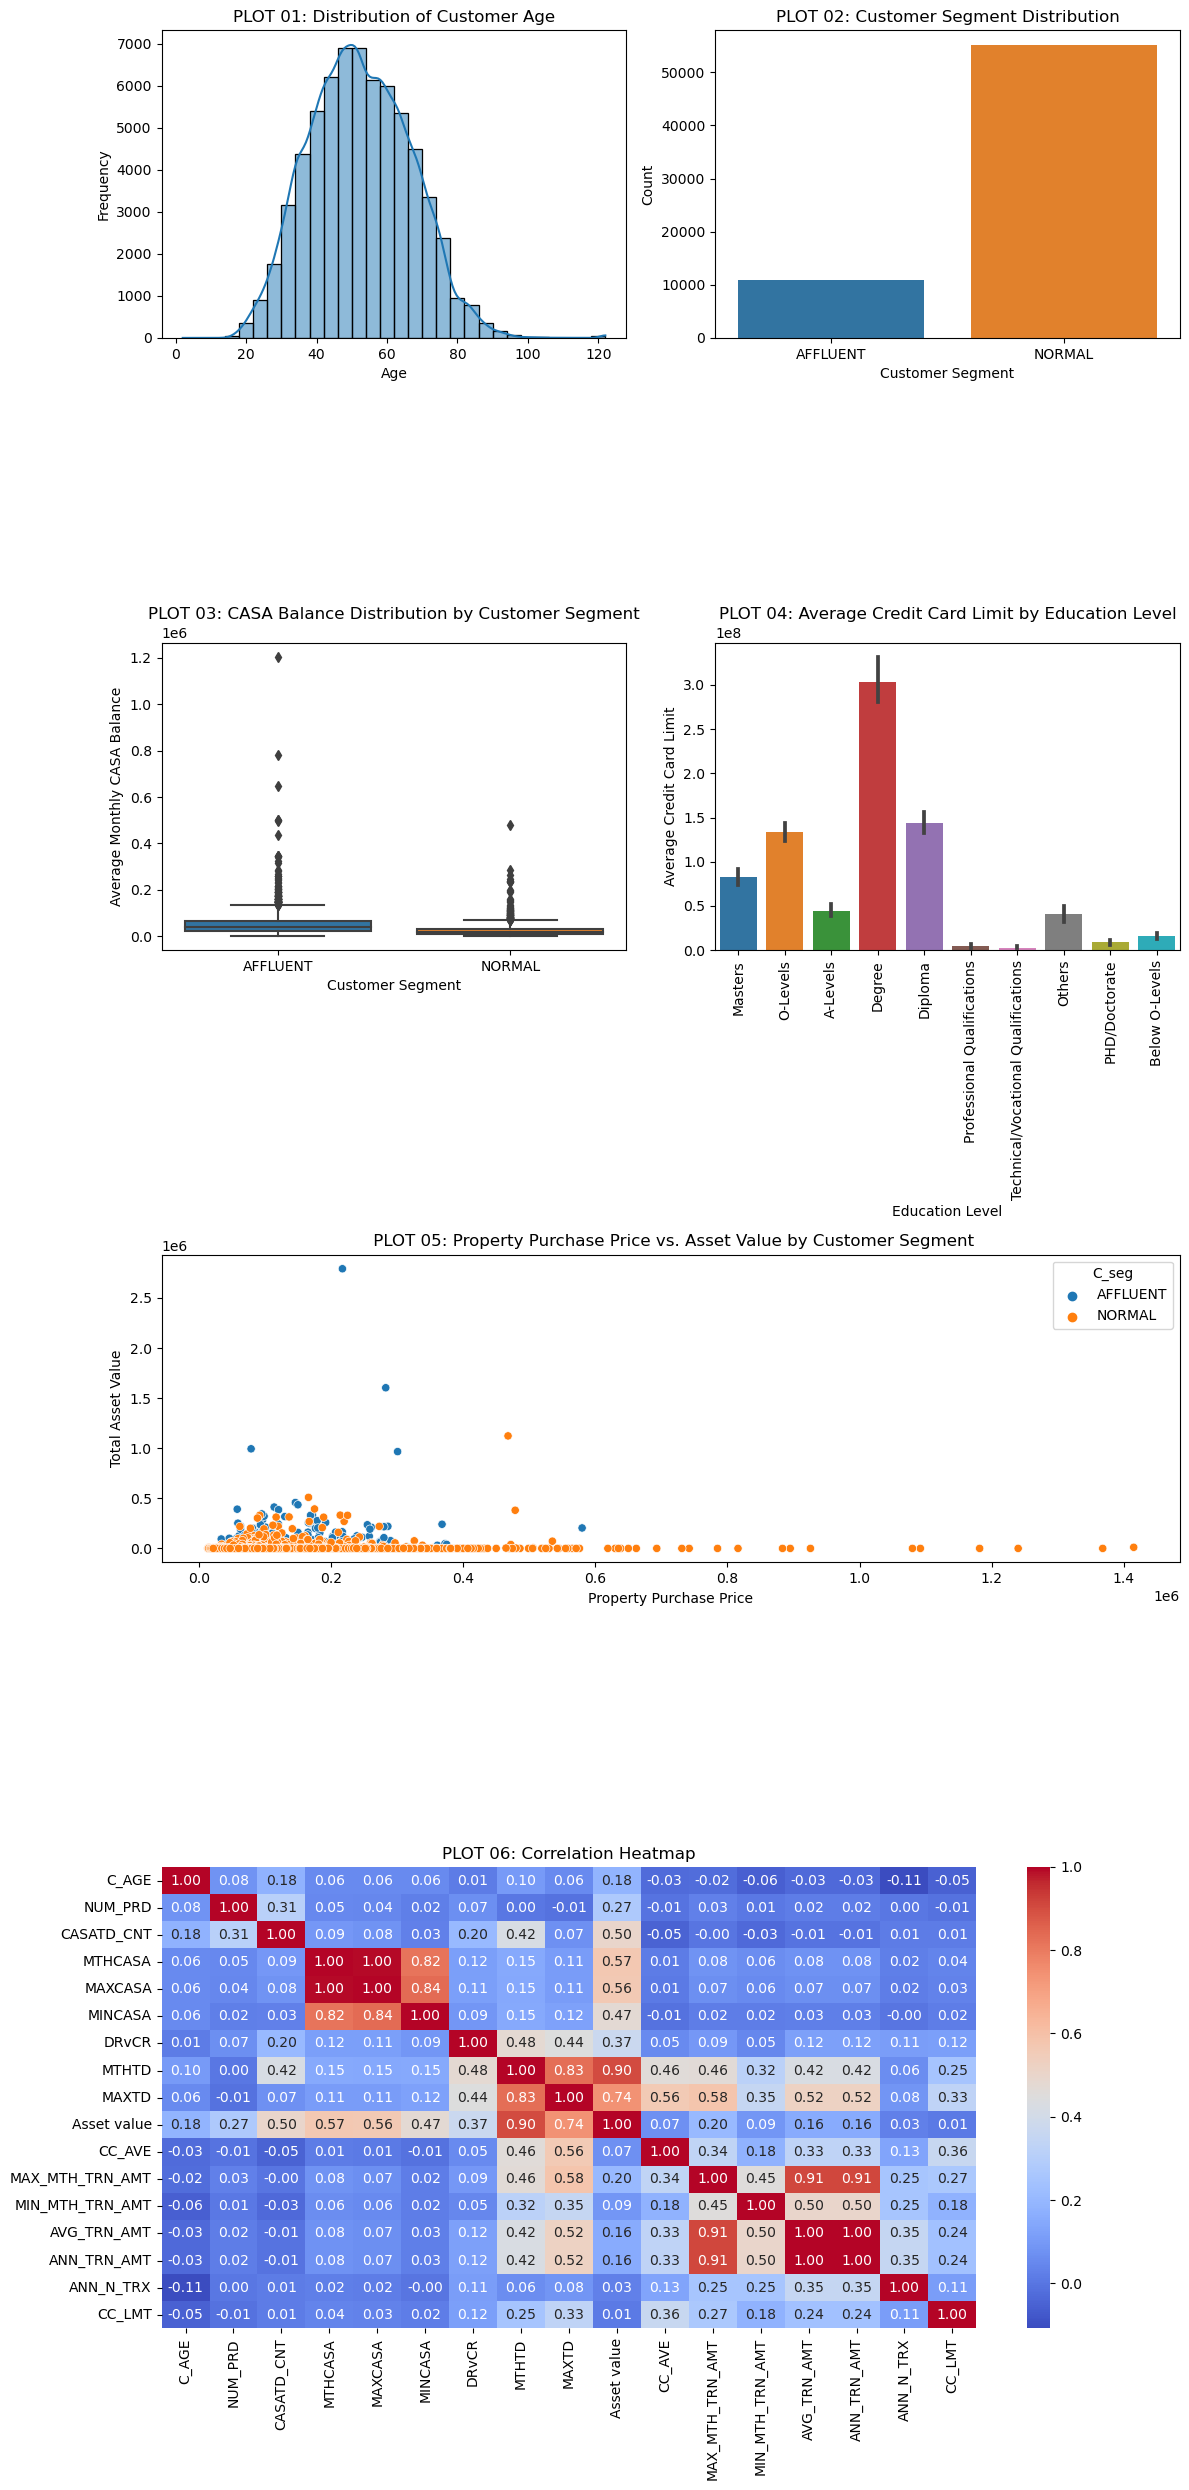

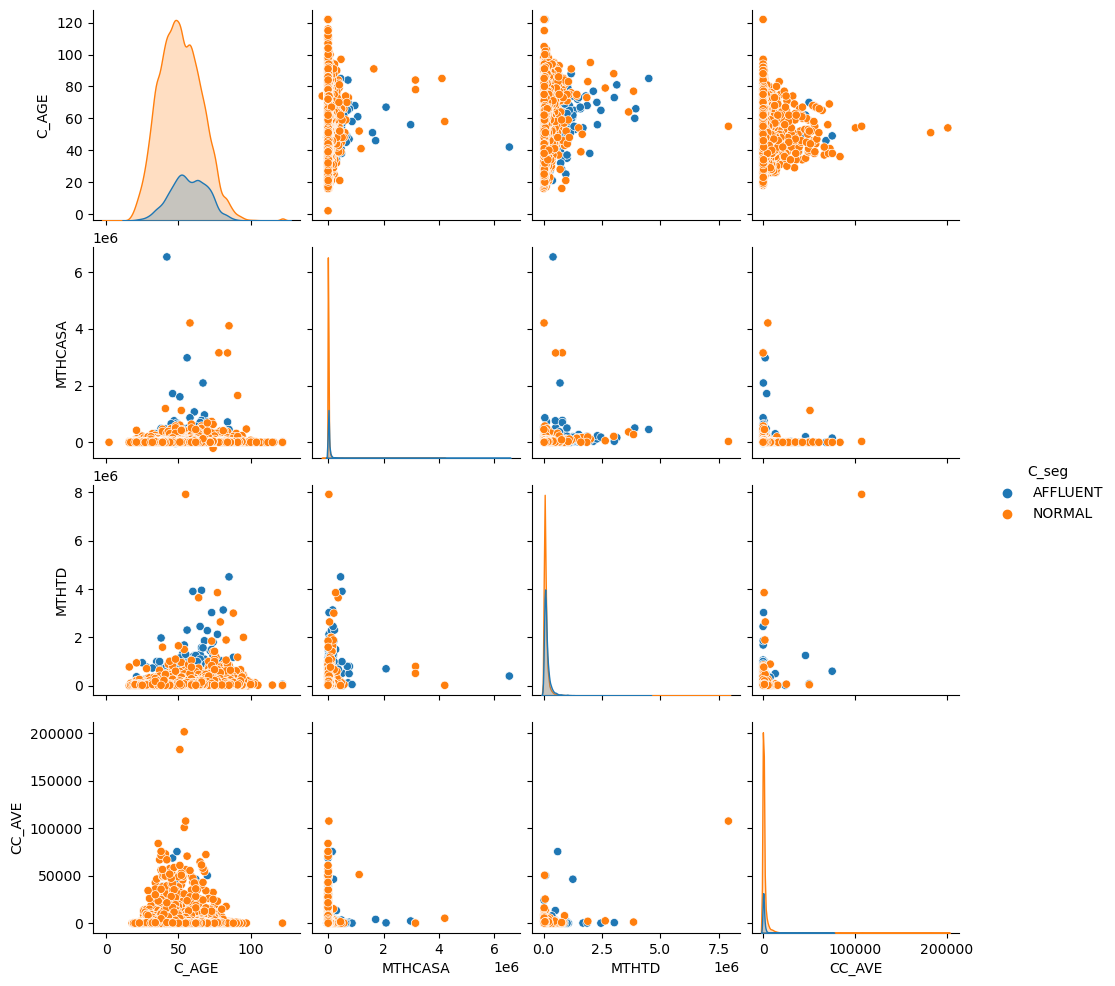

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Setting up the figure and subplots
fig = plt.figure(figsize=(12, 25))  
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1.5])  

# Plot 01: Distribution of Customer Age
ax0 = plt.subplot(gs[0, 0])
sns.histplot(raw_df['C_AGE'], bins=30, kde=True, ax=ax0)
ax0.set_title('PLOT 01: Distribution of Customer Age')
ax0.set_xlabel('Age')
ax0.set_ylabel('Frequency')

# Plot 02: Customer Segment Distribution
ax1 = plt.subplot(gs[0, 1])
sns.countplot(x='C_seg', data=raw_df, ax=ax1)
ax1.set_title('PLOT 02: Customer Segment Distribution')
ax1.set_xlabel('Customer Segment')
ax1.set_ylabel('Count')

# Plot 03: CASA Balance Distribution by Customer Segment
ax2 = plt.subplot(gs[1, 0])
sns.boxplot(x='C_seg', y='UT_AVE', data=raw_df, ax=ax2)
ax2.set_title('PLOT 03: CASA Balance Distribution by Customer Segment')
ax2.set_xlabel('Customer Segment')
ax2.set_ylabel('Average Monthly CASA Balance')

# Plot 04: Average Credit Card Limit by Education Level
ax4 = plt.subplot(gs[1, 1])
sns.barplot(x='C_EDU', y='Asset value', data=raw_df, estimator=sum, ax=ax4)
ax4.set_title('PLOT 04: Average Credit Card Limit by Education Level')
ax4.set_xlabel('Education Level')
ax4.set_ylabel('Average Credit Card Limit')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)  # Rotate labels to vertical

# Plot 05: Property Purchase Price vs. Asset Value by Customer Segment
ax5 = plt.subplot(gs[2, :])
sns.scatterplot(x='pur_price_avg', y='Asset value', data=raw_df, hue='C_seg', ax=ax5)
ax5.set_title(' PLOT 05: Property Purchase Price vs. Asset Value by Customer Segment')
ax5.set_xlabel('Property Purchase Price')
ax5.set_ylabel('Total Asset Value')

# Plot 06: Correlation Heatmap
ax3 = plt.subplot(gs[3, :])
numerical_cols = ['C_AGE', 'NUM_PRD', 'CASATD_CNT', 'MTHCASA', 'MAXCASA', 'MINCASA', 'DRvCR', 'MTHTD', 'MAXTD', 'Asset value', 'CC_AVE', 'MAX_MTH_TRN_AMT', 'MIN_MTH_TRN_AMT', 'AVG_TRN_AMT', 'ANN_TRN_AMT', 'ANN_N_TRX', 'CC_LMT']
corr_matrix = raw_df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax3)
ax3.set_title('PLOT 06: Correlation Heatmap')

plt.tight_layout()
plt.show()

# Plot 07: Pair Plot for Selected Numerical Variables
sns.pairplot(raw_df[['C_AGE', 'MTHCASA', 'MTHTD', 'CC_AVE', 'C_seg']], hue='C_seg')
plt.show()


---

## Section 02: Data Processing Techniques

Based on follow-up action items discussed in <b>`Section 01: Exploratory Data Analysis (EDA)`</b>
* <b>`Section 02.1`</b>: One-hot Encoding for Categorical Columns
* <b>`Section 02.2`</b>: Data Imputation to Numeric Columns with Missing Data
* <b>`Section 02.3`</b>: Data Scaling / Normalization
* <b>`Section 02.4`</b>: Feature Expansion on One-hot Encoded Categorical Columns [DATA_INIT]
  - `DATA_INIT`: Normalized dataset with all one-hot encoded categorical columns being expanded as separate columns in dataset. 
* <b>`Section 02.5`</b>: Data Augmentation to Resolve Data Imbalance [DATA_SMOTE, DATA_ADASYN]
  - `DATA_SMOTE`: Perform oversampling on minority customer segment <b>`AFFLUENT`</b> using <font color="blue">SMOTE</font> technique to resolve data imbalance issue on `DATA_INIT`
  - `DATA_ADASYN`: Perform oversampling on minority customer segment <b>`AFFLUENT`</b> using <font color="blue">ADASYN</font> technique to resolve data imbalance issue on `DATA_INIT`
* <b>`Section 02.6`</b>: Dimensionality Reduction with PCA Algorithm [DATA_INIT_RED, DATA_SMOTE_RED, DATA_ADASYN_RED]
  - `DATA_INIT_RED`: Perform dimensionality reduction using `PCA algorithm` on `DATA_INIT`
  - `DATA_SMOTE_RED`: Perform dimensionality reduction using `PCA algorithm` on `DATA_SMOTE`
  - `DATA_ADASYN_RED`: Perform dimensionality reduction using `PCA algorithm` on `DATA_ADASYN`

<br></br>

<u>**Summary of data imputation techniques for each dataset columns:**</u>
| COLUMN NAME   | DATA PROCESSING TECHNIQUE                                        |
|:-------------:|:----------------------------------------------------------------:|
|C_ID           | No missing data. Remains the same.                               |
|C_AGE          | No missing data. Remains the same.                               |
|C_EDU          | Use XGBOOST model to predict missing data based on existing data.|
|C_HSE          | Use XGBOOST model to predict missing data based on existing data.|   
|PC             | Missing data will be backfilled with arbitrary integer 100000.   |   
|INCM_TYP       | Fill with average.                                               |
|gn_occ         | Use XGBOOST model to predict missing data based on existing data.|   
|NUM_PRD        | No missing data. Remains the same.                               |
|CASATD_CNT     | Fill with average.                                               |
|MTHCASA        | Fill with average.                                               |
|MAXCASA        | Fill with average.                                               |
|MINCASA        | Fill with average.                                               |
|DRvCR          | Fill with average.                                               |
|MTHTD          | Fill with average.                                               |
|MAXTD          | Fill with average.                                               |
|Asset value    | No missing data. Remains the same.                               |
|HL_tag         | Drop the whole column.                                           |  
|AL_tag         | Drop the whole column.                                           |  
|pur_price_avg  | Drop the whole column.                                           |  
|UT_AVE         | Fill with zero.                                                  |
|MAXUT          | Fill with zero.                                                  |
|N_FUNDS        | Fill with zero.                                                  |
|CC_AVE         | Fill with zero.                                                  |
|MAX_MTH_TRN_AMT| Drop the whole column.                                           |  
|MIN_MTH_TRN_AMT| Drop the whole column.                                           |  
|AVG_TRN_AMT    | Drop the whole column.                                           |  
|ANN_TRN_AMT    | Drop the whole column.                                           |  
|ANN_N_TRX      | Drop the whole column.                                           |  
|CC_LMT         | Fill with zero.                                                  |
|C_seg          | No missing data. Map "NORMAL":0, "AFFLUENT":1.                   |


---

### Section 02.1: One-hot Encoding for Categorical Columns

Converting categorical columns [`C_EDU`, `C_HSE`, `gn_occ`] into one-hot encoding.

- For other categorical columns, I chose the approach to first learn the classification of the classes for each column using XGBOOST model and then use said model to predict the label for missing data. 
  - The model is first trained using columns with complete data as input features (such as `C_AGE`, `NUM_PRD`, and `Asset value`) and all non-missing data of a particular categorical column as target feature. 
    - Technically, the column `C_ID` also has complete data, but it will not participate in the model training for label prediction since it serves as unique identifiers for each record in the dataset.
  - Once trained,  the model is used to predict missing data of a particular categorical column based on associated complete columns. 
  - Here, we don’t do cross-validation parameter tuning for the XGBOOST model. Reason being is because we don’t want severe collinearity between categorical columns and the complete-data columns.
  - This is a best-effort categorical data imputation which is better than random imputation as it at least understands the nuance posed by complete-data columns but not so far off to overfit to them.

- As mentioned before, `C_seg` column will not be converted into one-hot encoding, but rather mapped into single integer value that varies for different customer segment.
  - 0 for <b>`NORMAL`</b> customers and 1 for <b>`AFFLUENT`</b> customers.

In [7]:
def generate_encode_dict(col, temp):
    unique_categories = list(set(temp[col]))
    print(f"Column \"{col}\" has {len(unique_categories)} unique categories, namely:\n{unique_categories}")
    return {val:i for i, val in enumerate(unique_categories)}


def onehot_encoding(col, temp, encode_prefix):
    unique_categories = list(set(temp[col]))
    encode_dict = generate_encode_dict(col, temp)
    print(f"\nencode_dict\n{encode_dict}")
    
    encode_col = col+encode_prefix
    temp[encode_col] = temp[col].apply(lambda x: encode_dict[x])
    temp[encode_col] = pd.DataFrame({col:to_categorical(temp[encode_col], num_classes=len(unique_categories)).tolist()})    
    return temp[encode_col]


def onehot_decoding(col, temp, decode_prefix, encode_col):
    encode_dict = generate_encode_dict(col, temp)
    decode_dict = {i:val for val, i in encode_dict.items()}
    decode_col = col+decode_prefix
    temp[decode_col] = np.asarray([decode_dict[np.asarray(u).argmax(0)] for u in temp[encode_col].tolist()])
    return temp[decode_col]


def convert_2dlist_to_ndarray(temp):
    temp = [np.asarray(onehot) for onehot in temp]
    temp = np.asarray(temp)
    return temp


def convert_ndarray_to_2dlist(temp):
    return [row for row in temp]



categorical_cols = ["C_EDU", "C_HSE", "gn_occ"]
complete_cols    = ["C_ID", "C_AGE", "NUM_PRD", "Asset value",]
excluded_cols    = "C_ID"
onehot_cols      = ["C_EDU", "C_HSE", "gn_occ"]
numeric_cols     = ["C_AGE", "INCM_TYP", "NUM_PRD", "CASATD_CNT", "MTHCASA", 
                    "MAXCASA", "MINCASA", "DRvCR", "MTHTD", "MAXTD", "Asset value", 
                    "UT_AVE", "MAXUT", "N_FUNDS", "CC_AVE", "CC_LMT"]
target_cols      = "C_seg" 
sorting_cols     = ["C_ID", "C_AGE", "PC"]

drop_cols        = ["HL_tag", "AL_tag", "pur_price_avg", "MAX_MTH_TRN_AMT", 
                    "MIN_MTH_TRN_AMT", "AVG_TRN_AMT", "ANN_TRN_AMT", "ANN_N_TRX"]
fillzero_cols    = ["UT_AVE", "MAXUT", "N_FUNDS", "CC_AVE", "CC_LMT"]
fillavg_cols     = ["INCM_TYP", "CASATD_CNT", "MTHCASA", "MAXCASA", "MINCASA", 
                    "DRvCR", "MTHTD", "MAXTD"]

# Reading in input ExCel file and sorted by `sorting_cols`
df = pd.read_excel("Assessment.xlsx", sheet_name="Data").sort_values(by=sorting_cols).reset_index(drop=True)

# Imputing column `PC` with 1 arbitrary number to missing rows 
# that still assert uniqueness among records with missing `PC` data
# as discussed in Section 01
df["PC"] = df["PC"].fillna(100000)
df["PC"] = df["PC"].apply(int)

# Adding column `PC` to `complete_cols`
complete_cols += ["PC"]

# Keeping track of mean and std of column `C_AGE`
C_AGE_stats = {"mean":df["C_AGE"].mean(), "std":df["C_AGE"].std()}

# Converting column `C_seg` to int64 type by dictionary mapping below
df[target_cols] = df[target_cols].map({"NORMAL":0, "AFFLUENT":1})

# Keeping track of unique records as identified by `sorting_cols`
reference_unique_records = df[sorting_cols+[target_cols]].values.tolist()


for col in tqdm(categorical_cols, desc=f"Converting categorical column...", ascii=False, ncols=75):
    # Getting a dataset snapshot consisting non-missing rows of categorical column `col` 
    # and rows from columns with complete data `complete_cols`
    notna_df = df[df[col].notna()]
    initial_notna_rows = notna_df.shape[0]
    notna_df = notna_df[complete_cols+[col]].reset_index(drop=True)
    
    # Dividing dataset into feature set and target set 
    # where feature columns are `complete_cols` and 
    # target column is the categorical column `col` in one-hot encoding format
    x = notna_df[notna_df.columns.difference([col])]
    y = onehot_encoding(col, notna_df, "_encode")
    y = convert_2dlist_to_ndarray(y)

    # Getting a dataset snapshot consisting missing rows from categorical column `col`
    # and rows from columns with complete data `complete_cols`
    isna_df = df[df[col].isna()]
    isna_df = isna_df[complete_cols+[col]].reset_index(drop=True)
    
    # Converting the dataset snapshot with aforesaid missing rows from categorical column `col` 
    # as unlabeled feature set whose target set (i.e. `y_unlabeled`) we want to predict using
    # XGBOOST model
    x_unlabeled = isna_df[isna_df.columns.difference([col])]

    # Dividing train and test set with 9:1 split from dataset with non-missing rows from categorical column `col`
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
    
    # Parameter grid for XGBOOST training
    params = {
        'max_depth': 8,
        'eta': 0.1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    }
    
    # Further preparing training and test dataset for XGBOOST model training
    dtrain = xgb.DMatrix(x_train[x_train.columns.difference([excluded_cols])], label=y_train)
    dtest = xgb.DMatrix(x_test[x_test.columns.difference([excluded_cols])], label=y_test)
    
    # Evaluate the predicted target set based on test set
    # Here, we don't do cross-vallidation parameter tuning for the XGBOOST model.
    # Reason being is because we don't want severe colinearity between categorical column `col` and `complete_cols`
    # That's why this is a best-effort categorical data imputation which is better than random imputation
    # as it at least understands the nuance posed by `complete_cols`
    y_pred = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "Test")], early_stopping_rounds=10, verbose_eval=False).predict(dtest)
    print("\nAccuracy Score:\n", accuracy_score(y_true=y_test.argmax(1), y_pred=y_pred.argmax(1)))
    print("\nClassification Report:\n", classification_report(y_true=y_test.argmax(1), y_pred=y_pred.argmax(1)))

    # Now, for the prediction on missing rows of categorical column `col`, we set
    # current training set to comprise of both previous training set and test set
    # while the current test set as `x_unlabeled` 
    dtrain = xgb.DMatrix(x[x.columns.difference([excluded_cols])], label=y)
    dunlabeled = xgb.DMatrix(x_unlabeled[x_unlabeled.columns.difference([excluded_cols])])
    y_unlabeled = xgb.train(params, dtrain, num_boost_round=100).predict(dunlabeled)

    # Combining the missing rows of `col` and newly predicted rows of `col` 
    # Then sorting them out based on `sorting_cols` before being used to overwrite the main dataset at column `col`
    y_df = pd.concat([pd.DataFrame({col:convert_ndarray_to_2dlist(y)}), pd.DataFrame({col:convert_ndarray_to_2dlist(y_unlabeled)})], axis=0)
    x_df = pd.concat([x, x_unlabeled], axis=0)
    col_df = pd.concat([x_df, y_df], axis=1).sort_values(by=sorting_cols).reset_index(drop=True)

    # Overwriting column `col` in main dataset based on consolidated dataset snapshot `col_df` in this iteration
    df[col] = col_df[col]
        
df

Converting categorical column...:   0%|              | 0/3 [00:00<?, ?it/s]

Column "C_EDU" has 10 unique categories, namely:
['Professional Qualifications', 'PHD/Doctorate', 'Masters', 'A-Levels', 'Diploma', 'Others', 'Below O-Levels', 'Degree', 'Technical/Vocational Qualifications', 'O-Levels']

encode_dict
{'Professional Qualifications': 0, 'PHD/Doctorate': 1, 'Masters': 2, 'A-Levels': 3, 'Diploma': 4, 'Others': 5, 'Below O-Levels': 6, 'Degree': 7, 'Technical/Vocational Qualifications': 8, 'O-Levels': 9}

Accuracy Score:
 0.4330195510499638

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.00      0.00      0.00        29
           2       0.38      0.02      0.04       251
           3       0.40      0.02      0.03       131
           4       0.26      0.09      0.13       643
           5       0.00      0.00      0.00       102
           6       0.00      0.00      0.00        37
           7       0.47      0.87      0.61      1091
           8   

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Column "C_HSE" has 14 unique categories, namely:
['HDB EXECUTIVE APARTMENT/ MANSIONETTE', 'BUNGALOW', 'PRIVATE APARTMENT', 'HDB 1-3 ROOM', 'OFFICE', 'TERRACE', 'PRIVATE CONDOMINIUM', 'HDB 4-5 ROOM', 'HOTEL/ SERVICE APARTMENT', 'SEMI-DETACHED', 'EXECUTIVE CONDOMINIUM', 'COMMERICAL BUILDING', 'INDUSTRIAL BUILDING', 'SHOPHOUSE']

encode_dict
{'HDB EXECUTIVE APARTMENT/ MANSIONETTE': 0, 'BUNGALOW': 1, 'PRIVATE APARTMENT': 2, 'HDB 1-3 ROOM': 3, 'OFFICE': 4, 'TERRACE': 5, 'PRIVATE CONDOMINIUM': 6, 'HDB 4-5 ROOM': 7, 'HOTEL/ SERVICE APARTMENT': 8, 'SEMI-DETACHED': 9, 'EXECUTIVE CONDOMINIUM': 10, 'COMMERICAL BUILDING': 11, 'INDUSTRIAL BUILDING': 12, 'SHOPHOUSE': 13}

Accuracy Score:
 0.7401894451962111

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         9
 

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Column "gn_occ" has 7 unique categories, namely:
['WHITE COLLAR', 'RETIREE', 'BLUE COLLAR', 'PMEB', 'HOUSEWIFE', 'OTHERS', 'STUDENT']

encode_dict
{'WHITE COLLAR': 0, 'RETIREE': 1, 'BLUE COLLAR': 2, 'PMEB': 3, 'HOUSEWIFE': 4, 'OTHERS': 5, 'STUDENT': 6}

Accuracy Score:
 0.5704646526606348

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       526
           1       0.44      0.56      0.49       488
           2       0.34      0.02      0.04       729
           3       0.60      0.95      0.73      3491
           4       0.26      0.08      0.12       604
           5       0.38      0.01      0.02       564
           6       0.58      0.50      0.54       119

    accuracy                           0.57      6521
   macro avg       0.37      0.30      0.28      6521
weighted avg       0.46      0.57      0.46      6521



Converting categorical column...: 100%|██████| 3/3 [00:35<00:00, 11.89s/it]


C_ID  C_AGE                                              C_EDU   
0          0     31  [0.029429859, 0.0021237868, 0.025331456, 0.020...  \
1          0     61  [0.0035734333, 0.0048716255, 0.10164958, 0.039...   
2          2     41  [0.04531954, 0.019259464, 0.046791274, 0.01455...   
3          8     70  [0.0023532275, 0.0039286264, 0.13788047, 0.053...   
4          9     44  [0.007068567, 0.042398565, 0.17124006, 0.02892...   
...      ...    ...                                                ...   
66078  99977     30  [0.009374642, -8.3766194e-05, 0.03446049, 0.01...   
66079  99980     45  [0.008722949, 0.0048361756, 0.12980635, 0.0057...   
66080  99989     47  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
66081  99990     41  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
66082  99996     42  [0.049246915, 0.007244671, 0.057295766, 0.0169...   

                                                   C_HSE     PC  INCM_TYP   
0      [5.355732e-05, -4.695544e-05, 0.00024672443, 2...  20184       2.0  \
1      [-0.00039313902, 0.00052700116, -0.0005689482,...  29894       NaN   
2      [-1.4207662e-06, 0.0011046382, 0.00022325254, ...  10461       4.0   
3      [0.001656539, 0.000119997334, -0.00036193652, ...  58518       NaN   
4      [-0.00022550997, 0.0024971957, 0.002937722, 0....      0       NaN   
...                                                  ...    ...       ...   
66078  [-0.0033093425, -0.00060272706, 0.002672284, -...      0       NaN   
66079  [0.00047290695, 0.00016877202, 0.00038181865, ...  41670       NaN   
66080  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  29525       5.0   
66081  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  81005       2.0   
66082  [0.0003232196, 0.00038724073, -4.2111595e-05, ...  22209       NaN   

                                    gn_occ  NUM_PRD  CASATD_CNT    MTHCASA   
0      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        1         NaN        NaN  \
1      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]        2         1.0   35373.02   
2      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        1         NaN        NaN   
3      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        3         3.0    8502.87   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]        2         3.0  100688.16   
...                                    ...      ...         ...        ...   
66078  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]        1         1.0     584.77   
66079  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]        2         1.0    2202.26   
66080  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        1         NaN        NaN   
66081  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        2         NaN        NaN   
66082  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        2         1.0    5810.69   

       ...  MAXUT  N_FUNDS       CC_AVE  MAX_MTH_TRN_AMT  MIN_MTH_TRN_AMT   
0      ...    NaN      NaN          NaN              NaN              NaN  \
1      ...    NaN      NaN          NaN              NaN              NaN   
2      ...    NaN      NaN          NaN              NaN              NaN   
3      ...    NaN      NaN          NaN              NaN              NaN   
4      ...    NaN      NaN          NaN              NaN              NaN   
...    ...    ...      ...          ...              ...              ...   
66078  ...    NaN      NaN          NaN              NaN              NaN   
66079  ...    NaN      NaN          NaN              NaN              NaN   
66080  ...    NaN      NaN  1903.238333          4521.98            19.46   
66081  ...    NaN      NaN    16.135833              NaN              NaN   
66082  ...    NaN      NaN          NaN              NaN              NaN   

       AVG_TRN_AMT  ANN_TRN_AMT  ANN_N_TRX   CC_LMT  C_seg  
0              NaN          NaN        NaN      NaN      0  
1              NaN          NaN        NaN      0.0      1  
2              NaN          NaN        NaN      NaN      0  
3              NaN          NaN        NaN      0.0      0  
4              NaN         

In [8]:
# Printing mean and std statistics for column `C_AGE`
C_AGE_stats

{'mean': 52.35742929346428, 'std': 14.32344671771608}

In [9]:
# Printing list of unique reference records
reference_unique_records

[[0, 31, 20184, 0],
 [0, 61, 29894, 1],
 [2, 41, 10461, 0],
 [8, 70, 58518, 0],
 [9, 44, 0, 0],
 [11, 70, 9259, 0],
 [11, 70, 22167, 0],
 [12, 39, 20845, 0],
 [13, 30, 70138, 0],
 [17, 59, 62315, 0],
 [18, 69, 56112, 0],
 [19, 35, 22614, 0],
 [19, 40, 71550, 0],
 [23, 48, 89669, 0],
 [23, 55, 30704, 0],
 [28, 37, 83487, 0],
 [30, 47, 70111, 0],
 [33, 71, 42, 0],
 [41, 55, 57053, 1],
 [42, 60, 47714, 0],
 [47, 49, 9050, 0],
 [49, 40, 66026, 0],
 [53, 46, 53075, 0],
 [54, 27, 83688, 0],
 [54, 73, 75176, 0],
 [55, 76, 49031, 0],
 [56, 48, 50310, 0],
 [59, 59, 69625, 0],
 [68, 45, 66664, 0],
 [69, 38, 43662, 1],
 [69, 47, 37475, 0],
 [69, 53, 58968, 0],
 [69, 64, 16940, 0],
 [71, 62, 9477, 1],
 [73, 49, 30314, 0],
 [75, 36, 58806, 0],
 [76, 48, 66026, 1],
 [78, 68, 87018, 0],
 [81, 73, 51450, 0],
 [84, 42, 60166, 0],
 [87, 27, 50, 0],
 [88, 67, 30241, 0],
 [90, 26, 40191, 0],
 [90, 33, 31, 0],
 [92, 45, 9955, 0],
 [95, 66, 20003, 0],
 [96, 56, 60225, 1],
 [97, 38, 30842, 0],
 [99, 54, 1000

In [10]:
# Confirming that there is no missing data on `categorical_columns` post data imputation in this Section 02.1
print(f"Is there any missing data in categorical columns {[col for col in categorical_cols]} after imputation:\n{df[[col for col in categorical_cols]].isna().any()}")

Is there any missing data in categorical columns ['C_EDU', 'C_HSE', 'gn_occ'] after imputation:
C_EDU     False
C_HSE     False
gn_occ    False
dtype: bool


---

### Section 02.2: Data Imputation to Numeric Columns with Missing Data

There are several strategies used to perform data imputation depending to the nature of each column:
- <font color="blue">Drop whole column</font>
  - This strategy fits those columns that have >80% of its data missing for both  <b>`NORMAL`</b> and <b>`AFFLUENT`</b> customer segments, and/or less relevant features for building customer segmentation, rendering them unhelpful for the model training.
  
  - <font color="red">Eligible numeric features:</font> 
    - `HL_tag`, `AL_tag`, `pur_price_avg`: Missing percentage by customer segment is >90% for both <b>`NORMAL`</b> and <b>`AFFLUENT`</b> customers. Further, the distribution spread measures (e.g. `mean` and `median`) are comparable between the 2 customer segments. Qualitatively speaking, presence of loan does not really indicate one's wealth and property purchase price can be reflected by more representative and collective feature like `Asset value`.
    - `MAX_MTH_TRN_AMT`, `MIN_MTH_TRN_AMT`, `AVG_TRN_AMT`, `ANN_TRN_AMT`, `ANN_N_TRX`: Other than >80% missing rate in both <b>`NORMAL`</b> and <b>`AFFLUENT`</b> customers, transaction amount-related features are not as representative as feature `Asset value`. So they are less relevant, and can be dropped entirely. 
    
- <font color="blue">Fill with zero</font>
  - This strategy fits those columns that are relevant and it's implicitly making sense to have low number of presence in the pool of bank customers. 
  - <font color="red">Eligible numeric features:</font> 
    - `UT_AVE`, `MAXUT`, `N_FUNDS`: Features related to investment products belong to this category where it makes sense for only few people with excess cashflow are able to invest, making them more promising to be upgraded as <b>`AFFLUENT`</b> customers. This statement is evidently supported by the fact that the missing percentage for <b>`AFFLUENT`</b> segment is smaller by around 10% compared to <b>`NORMAL`</b> segment. So missing data can just be backfilled with zero.
    - `CC_AVE`, `CC_LMT`: Traditional bank customers tend to be risk-averse and avoid credit card debt due to fear of being unable to pay the bill. However, most of high-profile bank customers would normally possess credit card for their day-to-day business dealings and to get rebates on expenses. So missing data can just be backfilled with zero.
  
- <font color="blue">Fill with average</font>
  - This strategy fits the remaining columns that do not fit aforementioned categories.  
  - <font color="red">Eligible numeric features:</font> `INCM_TYP`, `CASATD_CNT`, `MTHCASA`, `MAXCASA`, `MINCASA`, `DRvCR`, `MTHTD`, `MAXTD`.

In [11]:
# Checking percentage of missing rows for each column which is grouped by `C_seg` column (i.e. `target_cols`)
df.groupby(target_cols).apply(lambda x: x.isna().mean() * 100).T

C_seg                    0          1
C_ID              0.000000   0.000000
C_AGE             0.000000   0.000000
C_EDU             0.000000   0.000000
C_HSE             0.000000   0.000000
PC                0.000000   0.000000
INCM_TYP         42.814149  53.551162
gn_occ            0.000000   0.000000
NUM_PRD           0.000000   0.000000
CASATD_CNT       44.186595   6.589786
MTHCASA          46.906104  10.671792
MAXCASA          46.906104  10.671792
MINCASA          46.906104  10.671792
DRvCR            60.913393  25.416438
MTHTD            85.474192  44.279700
MAXTD            85.474192  44.279700
Asset value       0.000000   0.000000
HL_tag           96.631434  95.332235
AL_tag           90.369309  97.483068
pur_price_avg    90.372935  97.483068
UT_AVE           98.477075  83.177741
MAXUT            98.477075  83.177741
N_FUNDS          98.477075  83.177741
CC_AVE           73.281723  78.619806
MAX_MTH_TRN_AMT  81.980528  83.580450
MIN_MTH_TRN_AMT  81.980528  83.580450
AVG_TRN_AMT      81.980528  83.580450
ANN_TRN_AMT      81.980528  83.580450
ANN_N_TRX        81.980528  83.580450
CC_LMT           28.924706  21.828666
C_seg             0.000000   0.000000

In [12]:
# Dropping all columns listed in `drop_cols` due to their high percentage of missing rows 
# and/or irrelevancy to this project objective
for col in drop_cols:
    if col in df.columns:
        del df[col]

# Filling zeros to all columns listed in `fillzero_cols` which is appropriate
# due to their inherent nature
for col in fillzero_cols:
    df[col] = df[col].fillna(0)

# Filling with average to all columns listed in `fillavg_cols` as they don't fall to 
# any of previous 2 categories of imputation.
for col in fillavg_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mean())

df

C_ID  C_AGE                                              C_EDU   
0          0     31  [0.029429859, 0.0021237868, 0.025331456, 0.020...  \
1          0     61  [0.0035734333, 0.0048716255, 0.10164958, 0.039...   
2          2     41  [0.04531954, 0.019259464, 0.046791274, 0.01455...   
3          8     70  [0.0023532275, 0.0039286264, 0.13788047, 0.053...   
4          9     44  [0.007068567, 0.042398565, 0.17124006, 0.02892...   
...      ...    ...                                                ...   
66078  99977     30  [0.009374642, -8.3766194e-05, 0.03446049, 0.01...   
66079  99980     45  [0.008722949, 0.0048361756, 0.12980635, 0.0057...   
66080  99989     47  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
66081  99990     41  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
66082  99996     42  [0.049246915, 0.007244671, 0.057295766, 0.0169...   

                                                   C_HSE     PC  INCM_TYP   
0      [5.355732e-05, -4.695544e-05, 0.00024672443, 2...  20184  2.000000  \
1      [-0.00039313902, 0.00052700116, -0.0005689482,...  29894  3.791709   
2      [-1.4207662e-06, 0.0011046382, 0.00022325254, ...  10461  4.000000   
3      [0.001656539, 0.000119997334, -0.00036193652, ...  58518  3.791709   
4      [-0.00022550997, 0.0024971957, 0.002937722, 0....      0  3.791709   
...                                                  ...    ...       ...   
66078  [-0.0033093425, -0.00060272706, 0.002672284, -...      0  3.791709   
66079  [0.00047290695, 0.00016877202, 0.00038181865, ...  41670  3.791709   
66080  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  29525  5.000000   
66081  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  81005  2.000000   
66082  [0.0003232196, 0.00038724073, -4.2111595e-05, ...  22209  3.791709   

                                    gn_occ  NUM_PRD  CASATD_CNT   
0      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        1    1.727867  \
1      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]        2    1.000000   
2      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        1    1.727867   
3      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        3    3.000000   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]        2    3.000000   
...                                    ...      ...         ...   
66078  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]        1    1.000000   
66079  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]        2    1.000000   
66080  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        1    1.727867   
66081  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        2    1.727867   
66082  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]        2    1.000000   

             MTHCASA  ...         DRvCR          MTHTD          MAXTD   
0       16145.983287  ...  36632.010240  107548.031806   67389.585294  \
1       35373.020000  ...      3.346907  107548.031806   67389.585294   
2       16145.983287  ...  36632.010240  107548.031806   67389.585294   
3        8502.870000  ...  36632.010240  152956.190000  101006.190000   
4      100688.160000  ...  36632.010240  107548.031806   67389.585294   
...              ...  ...           ...            ...            ...   
66078     584.770000  ...  36632.010240  107548.031806   67389.585294   
66079    2202.260000  ...   5020.000000  107548.031806   67389.585294   
66080   16145.983287  ...  36632.010240  107548.031806   67389.585294   
66081   16145.983287  ...  36632.010240  107548.031806   67389.585294   
66082    5810.690000  ...    478.323000  107548.031806   67389.585294   

       Asset value  UT_AVE  MAXUT  N_FUNDS       CC_AVE   CC_LMT  C_seg  
0             0.00     0.0    0.0      0.0     0.000000      0.0      0  
1         35373.02     0.0    0.0      0.0     0.000000      0.0      1  
2             0.00     0.0    0.0      0.0     0.000000      0.0      0  
3        161459.06     0.0    0.0      0.0     0.000000      0.0      0  
4        100688.16     0.0    0.0      0.0     0.000000      0.0      0  
...            ...     ...    ...      ...          ...      ...    

---

### Section 02.3: Data Scaling / Normalization

We will do standard normalization on all numeric columns by substracting each column by its mean and then dividing it by its standard deviation.


In [13]:
# Performing standard normalization by substracting each column with its mean and dividing it by its std
df[numeric_cols] = (df[numeric_cols]-df[numeric_cols].mean())/df[numeric_cols].std()
df

C_ID     C_AGE                                              C_EDU   
0          0 -1.491082  [0.029429859, 0.0021237868, 0.025331456, 0.020...  \
1          0  0.603386  [0.0035734333, 0.0048716255, 0.10164958, 0.039...   
2          2 -0.792926  [0.04531954, 0.019259464, 0.046791274, 0.01455...   
3          8  1.231727  [0.0023532275, 0.0039286264, 0.13788047, 0.053...   
4          9 -0.583479  [0.007068567, 0.042398565, 0.17124006, 0.02892...   
...      ...       ...                                                ...   
66078  99977 -1.560897  [0.009374642, -8.3766194e-05, 0.03446049, 0.01...   
66079  99980 -0.513663  [0.008722949, 0.0048361756, 0.12980635, 0.0057...   
66080  99989 -0.374032  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
66081  99990 -0.792926  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
66082  99996 -0.723110  [0.049246915, 0.007244671, 0.057295766, 0.0169...   

                                                   C_HSE     PC  INCM_TYP   
0      [5.355732e-05, -4.695544e-05, 0.00024672443, 2...  20184 -1.401160  \
1      [-0.00039313902, 0.00052700116, -0.0005689482,...  29894  0.000000   
2      [-1.4207662e-06, 0.0011046382, 0.00022325254, ...  10461  0.162889   
3      [0.001656539, 0.000119997334, -0.00036193652, ...  58518  0.000000   
4      [-0.00022550997, 0.0024971957, 0.002937722, 0....      0  0.000000   
...                                                  ...    ...       ...   
66078  [-0.0033093425, -0.00060272706, 0.002672284, -...      0  0.000000   
66079  [0.00047290695, 0.00016877202, 0.00038181865, ...  41670  0.000000   
66080  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  29525  0.944914   
66081  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  81005 -1.401160   
66082  [0.0003232196, 0.00038724073, -4.2111595e-05, ...  22209  0.000000   

                                    gn_occ   NUM_PRD    CASATD_CNT   
0      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] -1.004484  1.997659e-16  \
1      [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0] -0.089639 -6.548371e-01   
2      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] -1.004484  1.997659e-16   
3      [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]  0.825206  1.144494e+00   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] -0.089639  1.144494e+00   
...                                    ...       ...           ...   
66078  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] -1.004484 -6.548371e-01   
66079  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] -0.089639 -6.548371e-01   
66080  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] -1.004484  1.997659e-16   
66081  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] -0.089639  1.997659e-16   
66082  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] -0.089639 -6.548371e-01   

            MTHCASA  ...     DRvCR         MTHTD         MAXTD  Asset value   
0     -3.540681e-17  ...  0.000000 -3.558681e-16 -5.400882e-16    -0.310625  \
1      3.742562e-01  ... -0.410722 -3.558681e-16 -5.400882e-16    -0.005973   
2     -3.540681e-17  ...  0.000000 -3.558681e-16 -5.400882e-16    -0.310625   
3     -1.487740e-01  ...  0.000000  5.552299e-01  6.238330e-01     1.079949   
4      1.645622e+00  ...  0.000000 -3.558681e-16 -5.400882e-16     0.556557   
...             ...  ...       ...           ...           ...          ...   
66078 -3.029006e-01  ...  0.000000 -3.558681e-16 -5.400882e-16    -0.305589   
66079 -2.714160e-01  ... -0.354469 -3.558681e-16 -5.400882e-16    -0.291658   
66080 -3.540681e-17  ...  0.000000 -3.558681e-16 -5.400882e-16    -0.310625   
66081 -3.540681e-17  ...  0.000000 -3.558681e-16 -5.400882e-16    -0.310625   
66082 -2.011775e-01  ... -0.405396 -3.558681e-16 -5.400882e-16    -0.260580   

         UT_AVE     MAXUT   N_FUNDS    CC_AVE    CC_LMT  C_seg  
0     -0.130369 -0.131333 -0.172392 -0.141026 -0.339913      0  
1     -0.130369 -0.131333 -0.172392 -0.141026 -0.339913      1  
2     -0.130369 -0.131333 -0.172392 -0.141026 -0.339913      0  
3     -0.130369 -0.131333 -0.172392 -0.141026 -0.339913      0  
4     -0.130369 -0.131333 -0.172392 -0.1410

In [157]:
# Printing dataset post normalization
# It can be seen that the mean is practically zero and std is 1
df.describe().loc[["mean", "std"]].T.loc[numeric_cols]

mean  std
C_AGE        7.526594e-17  1.0
INCM_TYP    -5.773973e-17  1.0
NUM_PRD      1.426827e-16  1.0
CASATD_CNT   1.496717e-16  1.0
MTHCASA     -4.376177e-17  1.0
MAXCASA     -4.811644e-17  1.0
MINCASA     -3.779425e-17  1.0
DRvCR        2.688069e-19  1.0
MTHTD       -3.299874e-16  1.0
MAXTD       -5.332323e-16  1.0
Asset value  9.677050e-18  1.0
UT_AVE      -2.408510e-17  1.0
MAXUT        1.999924e-17  1.0
N_FUNDS      2.671941e-17  1.0
CC_AVE       1.042971e-17  1.0
CC_LMT       3.085904e-17  1.0

---

### Section 02.4: Feature Expansion on One-hot Encoded Categorical Columns [DATA_INIT]

Based on normalized dataset from <b>Section 02.3</b> previously, categorical columns in input features are expanded into separate columns
  - `DATA_INIT`: Normalized dataset with all one-hot encoded categorical columns being expanded as separate columns in dataset. 



In [14]:
#################
# DATA_INIT #####
#################

# Copying main dataset to DATA_INIT so as to not pontentially contaminate main dataset
DATA_INIT = df.copy()

# Expanding all one-hot encoded columns listed in `onehot_cols` into separate physical columns
for col in onehot_cols:
    temp_df = pd.DataFrame()
    temp_df = pd.DataFrame(DATA_INIT[col].tolist(), index=DATA_INIT.index)
    row_len = len(DATA_INIT.iloc[0][col])
    temp_df.columns = [f"{col}_index{i}" for i in range(row_len)]
    DATA_INIT = pd.concat([DATA_INIT, temp_df], axis=1)
    del DATA_INIT[col]

DATA_INIT

C_ID     C_AGE     PC  INCM_TYP   NUM_PRD    CASATD_CNT       MTHCASA   
0          0 -1.491082  20184 -1.401160 -1.004484  1.997659e-16 -3.540681e-17  \
1          0  0.603386  29894  0.000000 -0.089639 -6.548371e-01  3.742562e-01   
2          2 -0.792926  10461  0.162889 -1.004484  1.997659e-16 -3.540681e-17   
3          8  1.231727  58518  0.000000  0.825206  1.144494e+00 -1.487740e-01   
4          9 -0.583479      0  0.000000 -0.089639  1.144494e+00  1.645622e+00   
...      ...       ...    ...       ...       ...           ...           ...   
66078  99977 -1.560897      0  0.000000 -1.004484 -6.548371e-01 -3.029006e-01   
66079  99980 -0.513663  41670  0.000000 -0.089639 -6.548371e-01 -2.714160e-01   
66080  99989 -0.374032  29525  0.944914 -1.004484  1.997659e-16 -3.540681e-17   
66081  99990 -0.792926  81005 -1.401160 -0.089639  1.997659e-16 -3.540681e-17   
66082  99996 -0.723110  22209  0.000000 -0.089639 -6.548371e-01 -2.011775e-01   

            MAXCASA   MINCASA     DRvCR  ...  C_HSE_index11  C_HSE_index12   
0     -7.275189e-17  0.000000  0.000000  ...       0.000016       0.000018  \
1      3.985142e-01  0.530455 -0.410722  ...       0.000016       0.000018   
2     -7.275189e-17  0.000000  0.000000  ...       0.000016       0.000018   
3     -1.388320e-01 -0.111673  0.000000  ...       0.000016       0.000018   
4      3.814068e-01  0.451882  0.000000  ...       0.000016       0.000018   
...             ...       ...       ...  ...            ...            ...   
66078 -2.971773e-01 -0.300895  0.000000  ...       0.000016       0.000018   
66079 -2.648309e-01 -0.262241 -0.354469  ...       0.000016       0.000018   
66080 -7.275189e-17  0.000000  0.000000  ...       0.000000       0.000000   
66081 -7.275189e-17  0.000000  0.000000  ...       0.000000       0.000000   
66082 -1.926699e-01 -0.176009 -0.405396  ...       0.000016       0.000018   

       C_HSE_index13  gn_occ_index0  gn_occ_index1  gn_occ_index2   
0           0.003196            0.0            0.0            0.0  \
1           0.000218            0.0            0.0            0.0   
2           0.005822            0.0            0.0            0.0   
3          -0.000275            0.0            0.0            0.0   
4           0.027752            0.0            0.0            0.0   
...              ...            ...            ...            ...   
66078       0.008564            1.0            0.0            0.0   
66079       0.002643            0.0            0.0            1.0   
66080       0.000000            0.0            0.0            0.0   
66081       0.000000            0.0            0.0            0.0   
66082      -0.001615            0.0            0.0            0.0   

       gn_occ_index3  gn_occ_index4  gn_occ_index5  gn_occ_index6  
0                1.0            0.0            0.0            0.0  
1                0.0            1.0            0.0            0.0  
2                1.0            0.0            0.0            0.0  
3                1.0            0.0            0.0            0.0  
4                0.0            0.0            1.0            0.0  
...              ...            ...            ...            ...  
66078            0.0            0.0            0.0            0.0  
66079            0.0            0.0            0.0            0.0  
66080            1.0            0.0            0.0            0.0  
66081            1.0            0.0            0.0            0.0  
66082            1.0            0.0            0.0            0.0  

[66083 rows x 50 columns]

C_ID         C_AGE             PC      INCM_TYP       NUM_PRD   
count  66083.000000  6.608300e+04   66083.000000  6.608300e+04  6.608300e+04  \
mean   41321.249111  7.526594e-17   43667.066946 -5.773973e-17  1.426827e-16   
std    27485.202813  1.000000e+00   26032.061441  1.000000e+00  1.000000e+00   
min        0.000000 -3.515734e+00       0.000000 -2.183185e+00 -1.004484e+00   
25%    17402.000000 -7.231101e-01   21682.000000 -6.191358e-01 -1.004484e+00   
50%    37643.000000 -2.495414e-02   41203.000000  0.000000e+00 -8.963910e-02   
75%    62866.500000  7.430174e-01   60867.500000  1.628889e-01  8.252058e-01   
max    99996.000000  4.862138e+00  100000.000000  3.290987e+00  6.314275e+00   

         CASATD_CNT       MTHCASA       MAXCASA       MINCASA         DRvCR   
count  6.608300e+04  6.608300e+04  6.608300e+04  6.608300e+04  6.608300e+04  \
mean   1.496717e-16 -4.376177e-17 -4.811644e-17 -3.779425e-17  2.688069e-19   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -6.548371e-01 -4.390374e+00 -4.496531e+00 -5.319116e+00 -4.107593e-01   
25%   -6.548371e-01 -2.595891e-01 -2.545977e-01 -2.626428e-01 -3.440412e-01   
50%    1.997659e-16 -3.540681e-17 -7.275189e-17  0.000000e+00  0.000000e+00   
75%    1.997659e-16 -3.540681e-17 -7.275189e-17  0.000000e+00  0.000000e+00   
max    3.353246e+01  1.268870e+02  1.303741e+02  1.558511e+02  1.300540e+02   

       ...  C_HSE_index11  C_HSE_index12  C_HSE_index13  gn_occ_index0   
count  ...   66083.000000   66083.000000   66083.000000   66083.000000  \
mean   ...       0.000068       0.000027       0.005221       0.078318   
std    ...       0.007341       0.003890       0.052217       0.267123   
min    ...       0.000000       0.000000      -0.077487      -0.013375   
25%    ...       0.000000       0.000000      -0.000040       0.000000   
50%    ...       0.000016       0.000018       0.000000       0.000000   
75%    ...       0.000016       0.000018       0.000619       0.000000   
max    ...       1.000000       1.000000       1.000000       1.000000   

       gn_occ_index1  gn_occ_index2  gn_occ_index3  gn_occ_index4   
count   66083.000000   66083.000000   66083.000000   66083.000000  \
mean        0.073536       0.115769       0.534248       0.089733   
std         0.259910       0.317988       0.496260       0.284504   
min        -0.023854      -0.058064      -0.037575      -0.010010   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       1.000000       0.000000   
75%         0.000000       0.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       gn_occ_index5  gn_occ_index6  
count   66083.000000   66083.000000  
mean        0.088698       0.019694  
std         0.281972       0.136303  
min        -0.014875      -0.016963  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.260116  

[8 rows x 50 columns]

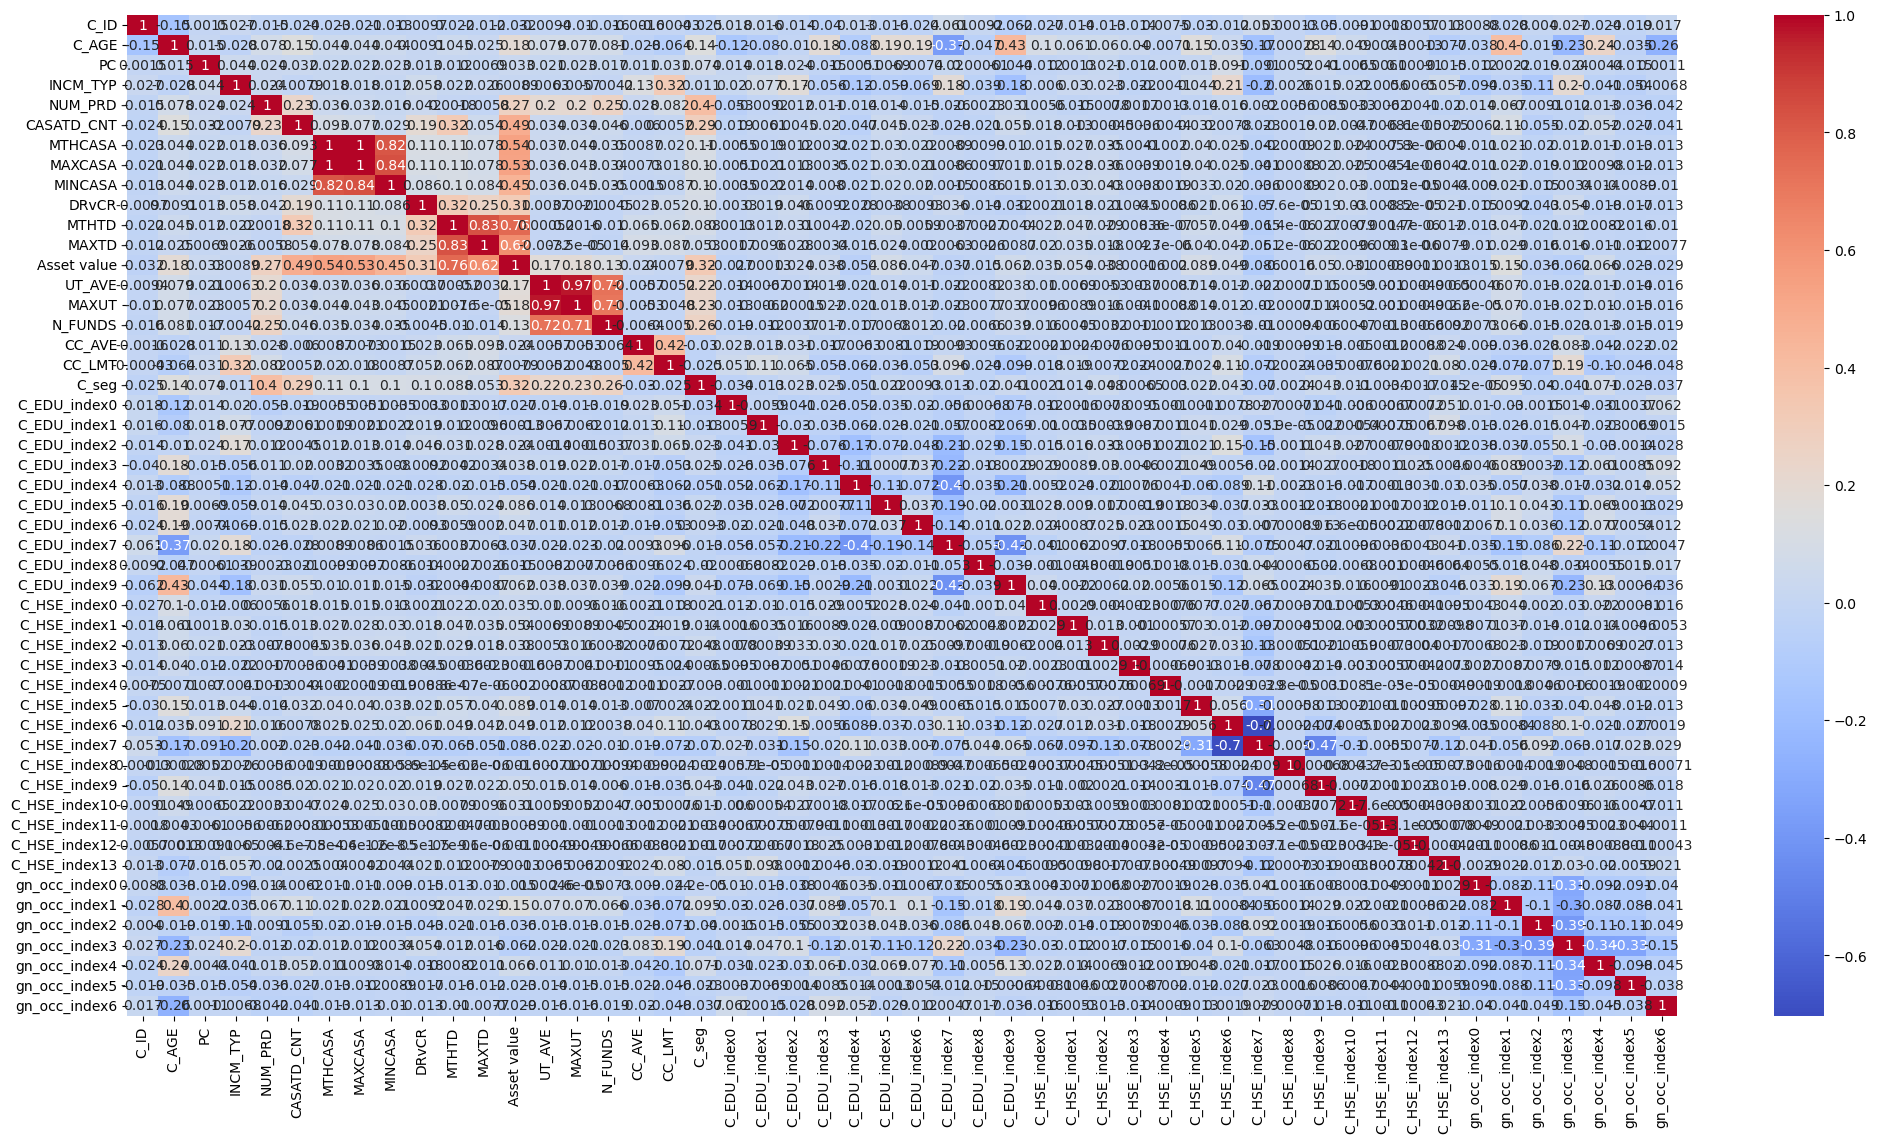

In [15]:
# Plotting correlation relationship for every pairwise columns.
# We can see that most of the columns are not correlated. 
# "lukewarm" correlation can be seen between CASA-related columns and `Asset value` column.
plt.figure(figsize=(25,13))
sns.heatmap(DATA_INIT.corr(), annot=True, cmap='coolwarm')

# Describing the statistics of DATA_INIT
# All columns have no missing data and that they are well normalized with mean=0 and std=1
DATA_INIT.describe()

In [16]:
# Printing the list of columns
DATA_INIT.columns

Index(['C_ID', 'C_AGE', 'PC', 'INCM_TYP', 'NUM_PRD', 'CASATD_CNT', 'MTHCASA',
       'MAXCASA', 'MINCASA', 'DRvCR', 'MTHTD', 'MAXTD', 'Asset value',
       'UT_AVE', 'MAXUT', 'N_FUNDS', 'CC_AVE', 'CC_LMT', 'C_seg',
       'C_EDU_index0', 'C_EDU_index1', 'C_EDU_index2', 'C_EDU_index3',
       'C_EDU_index4', 'C_EDU_index5', 'C_EDU_index6', 'C_EDU_index7',
       'C_EDU_index8', 'C_EDU_index9', 'C_HSE_index0', 'C_HSE_index1',
       'C_HSE_index2', 'C_HSE_index3', 'C_HSE_index4', 'C_HSE_index5',
       'C_HSE_index6', 'C_HSE_index7', 'C_HSE_index8', 'C_HSE_index9',
       'C_HSE_index10', 'C_HSE_index11', 'C_HSE_index12', 'C_HSE_index13',
       'gn_occ_index0', 'gn_occ_index1', 'gn_occ_index2', 'gn_occ_index3',
       'gn_occ_index4', 'gn_occ_index5', 'gn_occ_index6'],
      dtype='object')

---

### Section 02.5: Data Augmentation to Resolve Data Imbalance [DATA_SMOTE, DATA_ADASYN]
Data augmentation using SMOTE and ADASYN oversampling techniques to resampling minority customer segment <b>`AFFLUENT`</b>.
  - `SMOTE` technique is chosen because `SMOTE` generates synthetic samples through interpolation of several existing minority class instances, which helps the model generalize better rather than just memorizing the training data., hence mitigating overfitting. `SVMSMOTE` is the `SMOTE` variant chosen as it specifically targets the support vectors determined by an `SVM` classifier to guide the synthetic sample generation process.
  - `ADASYN` technique is chosen because `ADASYN` focuses on generating synthetic smaples next to the border line of the minority class, rather than randomly throughout the feature space. This emphasis on difficult-to-classify instances makes classifiers better at distinguishing close-to-border cases. Further, the number of synthetic samples generated for each minority class instance is proportional to the level of difficulty in learning that instance, allowing for an automatically balanced dataset that is tailored to the classifier’s needs.

  - `DATA_SMOTE`: Perform oversampling on minority customer segment <b>`AFFLUENT`</b> using <font color="blue">SMOTE</font> technique to resolve data imbalance issue on `DATA_INIT`
  - `DATA_ADASYN`: Perform oversampling on minority customer segment <b>`AFFLUENT`</b> using <font color="blue">ADASYN</font> technique to resolve data imbalance issue on `DATA_INIT`


In [17]:
# Inspecting the presence of data imbalance in DATA_INIT
AFFLUENT_count = DATA_INIT[DATA_INIT[target_cols]==1][target_cols].count()
NORMAL_count = DATA_INIT[DATA_INIT[target_cols]==0][target_cols].count()
print("DATA_INIT imbalance check:\n============================================")
print(f"AFFLUENT dataset count: {AFFLUENT_count} ({AFFLUENT_count/(AFFLUENT_count+NORMAL_count)*100:.2f}%)")
print(f"NORMAL dataset count: {NORMAL_count} ({NORMAL_count/(AFFLUENT_count+NORMAL_count)*100:.2f}%)")

DATA_INIT imbalance check:
AFFLUENT dataset count: 10926 (16.53%)
NORMAL dataset count: 55157 (83.47%)


In [18]:
###################
# DATA_SMOTE ######
###################

# Getting list of feature columns
feature_cols = [col for col in DATA_INIT.columns.tolist() if col!=target_cols]

# Oversampling the dataset with minority classes so that it can be balance with majority class
# No change on majority class
smote_x_resampled, smote_y_resampled = SVMSMOTE(random_state=42).fit_resample(DATA_INIT[feature_cols], DATA_INIT[target_cols])
DATA_SMOTE = pd.DataFrame(smote_x_resampled, columns=feature_cols)
DATA_SMOTE[target_cols] = smote_y_resampled
DATA_SMOTE[target_cols] = DATA_SMOTE[target_cols].apply(lambda x: 0 if x<0.50 else 1)

# Inspecting the presence of data imbalance upon oversampling
# No more data imbalance is detected
AFFLUENT_count = DATA_SMOTE[DATA_SMOTE[target_cols]==1][target_cols].count()
NORMAL_count = DATA_SMOTE[DATA_SMOTE[target_cols]==0][target_cols].count()
print("DATA_SMOTE imbalance check:\n============================================")
print(f"AFFLUENT dataset count: {AFFLUENT_count} ({AFFLUENT_count/(AFFLUENT_count+NORMAL_count)*100:.2f}%)")
print(f"NORMAL dataset count: {NORMAL_count} ({NORMAL_count/(AFFLUENT_count+NORMAL_count)*100:.2f}%)")

DATA_SMOTE

DATA_SMOTE imbalance check:
AFFLUENT dataset count: 55157 (50.00%)
NORMAL dataset count: 55157 (50.00%)


C_ID     C_AGE      PC  INCM_TYP   NUM_PRD    CASATD_CNT   
0           0 -1.491082   20184 -1.401160 -1.004484  1.997659e-16  \
1           0  0.603386   29894  0.000000 -0.089639 -6.548371e-01   
2           2 -0.792926   10461  0.162889 -1.004484  1.997659e-16   
3           8  1.231727   58518  0.000000  0.825206  1.144494e+00   
4           9 -0.583479       0  0.000000 -0.089639  1.144494e+00   
...       ...       ...     ...       ...       ...           ...   
110309  33524 -1.330006  100000  3.347809 -0.089639 -1.256425e+00   
110310  66373  2.641091  100000  0.000000  0.825206  2.385740e+00   
110311  67304 -1.895673  100000  0.000000  1.617578  1.066508e+01   
110312   3171  2.073656  100000  0.000000 -1.011721 -6.655125e-01   
110313  54649 -0.086784  100000  1.726938 -0.089639 -6.548371e-01   

             MTHCASA       MAXCASA   MINCASA     DRvCR  ...  C_HSE_index12   
0      -3.540681e-17 -7.275189e-17  0.000000  0.000000  ...       0.000018  \
1       3.742562e-01  3.985142e-01  0.530455 -0.410722  ...       0.000018   
2      -3.540681e-17 -7.275189e-17  0.000000  0.000000  ...       0.000018   
3      -1.487740e-01 -1.388320e-01 -0.111673  0.000000  ...       0.000018   
4       1.645622e+00  3.814068e-01  0.451882  0.000000  ...       0.000018   
...              ...           ...       ...       ...  ...            ...   
110309  7.361172e-02  9.432613e-02  0.185083 -0.305192  ...       0.000018   
110310 -5.085415e-01 -5.084469e-01 -0.553362  2.170538  ...       0.000018   
110311  2.746788e-01  3.022802e-01  0.438941 -0.588255  ...       0.000018   
110312  3.433112e+00  3.541095e+00  4.285835  0.000000  ...       0.000018   
110313 -3.472864e-01 -3.427780e-01 -0.355388 -0.161995  ...       0.000018   

        C_HSE_index13  gn_occ_index0  gn_occ_index1  gn_occ_index2   
0            0.003196            0.0       0.000000       0.000000  \
1            0.000218            0.0       0.000000       0.000000   
2            0.005822            0.0       0.000000       0.000000   
3           -0.000275            0.0       0.000000       0.000000   
4            0.027752            0.0       0.000000       0.000000   
...               ...            ...            ...            ...   
110309       0.001185            0.0       0.000000       0.000000   
110310      -0.025686            0.0       1.379674      -0.379674   
110311       0.000147            0.0       0.000000       1.433064   
110312      -0.002558            0.0       0.000000       1.000000   
110313      -0.000829            0.0       0.000000       0.000000   

        gn_occ_index3  gn_occ_index4  gn_occ_index5  gn_occ_index6  C_seg  
0            1.000000        0.00000            0.0            0.0      0  
1            0.000000        1.00000            0.0            0.0      1  
2            1.000000        0.00000            0.0            0.0      0  
3            1.000000        0.00000            0.0            0.0      0  
4            0.000000        0.00000            1.0            0.0      0  
...               ...            ...            ...            ...    ...  
110309       1.334340       -0.33434            0.0            0.0      1  
110310       0.000000        0.00000            0.0            0.0      1  
110311      -0.433064        0.00000            0.0            0.0      1  
110312       0.000000        0.00000            0.0            0.0      1  
110313       1.000000        0.00000            0.0            0.0      1  

[110314 rows x 50 columns]

C_ID          C_AGE             PC       INCM_TYP   
count  110314.000000  110314.000000  110314.000000  110314.000000  \
mean    40759.164222       0.081239   53507.339912       0.038597   
std     27196.467385       0.985613   31228.926364       0.969959   
min      -138.000000      -4.019532       0.000000      -4.136773   
25%     17484.000000      -0.591642   29587.250000      -0.181780   
50%     37299.500000       0.044861   50357.500000       0.000000   
75%     61073.750000       0.757890   80314.000000       0.162889   
max     99996.000000       7.260326  100660.000000       5.239822   

             NUM_PRD    CASATD_CNT       MTHCASA       MAXCASA        MINCASA   
count  110314.000000  1.103140e+05  1.103140e+05  1.103140e+05  110314.000000  \
mean        0.294663  2.302656e-01  1.822915e-01  1.823390e-01       0.201269   
std         1.080286  1.482222e+00  3.500043e+00  3.587490e+00       4.250972   
min        -3.001968 -9.335351e+00 -6.048588e+01 -6.214815e+01     -74.292794   
25%        -0.496812 -6.548371e-01 -2.397956e-01 -2.357064e-01      -0.248230   
50%        -0.089639  1.997659e-16 -3.540681e-17 -7.275189e-17      -0.005430   
75%         0.825206  2.448286e-01  1.490008e-02  1.135957e-02       0.000000   
max         6.763785  3.353246e+01  1.903278e+02  1.955514e+02     233.737854   

               DRvCR  ...  C_HSE_index12  C_HSE_index13  gn_occ_index0   
count  110314.000000  ...   1.103140e+05  110314.000000  110314.000000  \
mean        0.121848  ...   2.167753e-05       0.004373       0.073395   
std         1.531284  ...   3.010792e-03       0.044056       0.260774   
min       -10.485844  ...  -1.080804e-05      -0.085252      -0.499796   
25%        -0.348627  ...   7.593767e-07      -0.000202       0.000000   
50%         0.000000  ...   1.779151e-05       0.000000       0.000000   
75%         0.000000  ...   1.779151e-05       0.000575       0.000000   
max       130.053958  ...   1.000000e+00       1.000000       1.499588   

       gn_occ_index1  gn_occ_index2  gn_occ_index3  gn_occ_index4   
count  110314.000000  110314.000000  110314.000000  110314.000000  \
mean        0.087486       0.106804       0.531213       0.105079   
std         0.281348       0.316251       0.506900       0.310860   
min        -0.499987      -0.499360      -0.499804      -0.499920   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.758343       0.000000   
75%         0.000000       0.000000       1.000000       0.000000   
max         1.499010       1.499904       1.499987       1.499796   

       gn_occ_index5  gn_occ_index6          C_seg  
count  110314.000000  110314.000000  110314.000000  
mean        0.081765       0.014284       0.500000  
std         0.277915       0.117495       0.500002  
min        -0.499588      -0.499248       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.500000  
75%         0.000000       0.000000       1.000000  
max         1.499024       1.493734       1.000000  

[8 rows x 50 columns]

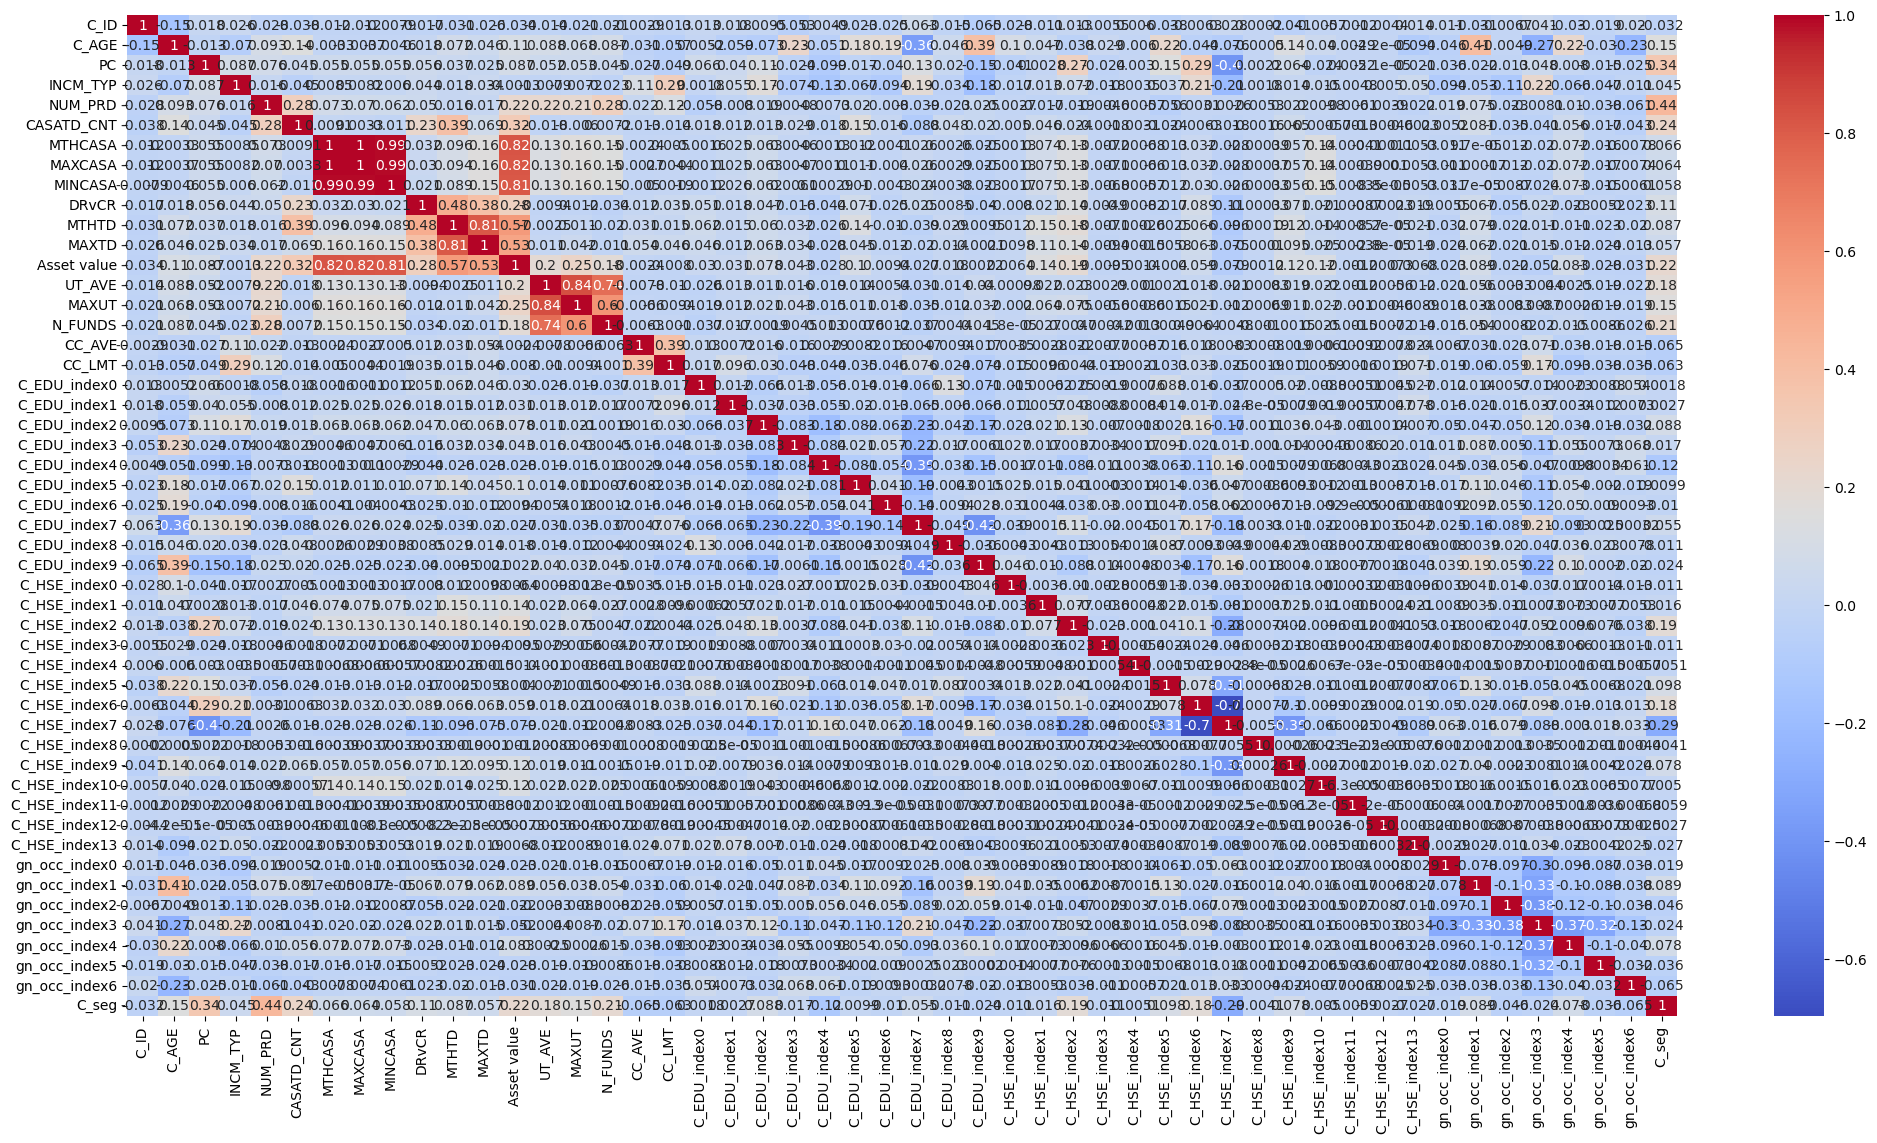

In [19]:
# Plotting correlation relationship for every pairwise columns.
# We can see that most of the columns are not correlated. 
# "lukewarm" correlation can be seen between CASA-related columns and `Asset value` column.
plt.figure(figsize=(25,13))
sns.heatmap(DATA_SMOTE.corr(), annot=True, cmap='coolwarm')

# Describing the statistics of DATA_SMOTE
# All columns have no missing data and that they are well normalized with mean=0 and std=1
DATA_SMOTE.describe()

In [20]:
###################
# DATA_ADASYN #####
###################

# Getting list of feature columns
feature_cols = [col for col in DATA_INIT.columns.tolist() if col!=target_cols]

# Oversampling the dataset with minority classes so that it can be balance with majority class
# No change on majority class
adasyn_x_resampled, adasyn_y_resampled = ADASYN(random_state=42).fit_resample(DATA_INIT[feature_cols], DATA_INIT[target_cols])
DATA_ADASYN = pd.DataFrame(adasyn_x_resampled, columns=feature_cols)
DATA_ADASYN[target_cols] = adasyn_y_resampled
DATA_ADASYN[target_cols] = DATA_ADASYN[target_cols].apply(lambda x: 0 if x<0.50 else 1)

# Inspecting the presence of data imbalance upon oversampling
# No more data imbalance is detected
AFFLUENT_count = DATA_ADASYN[DATA_ADASYN[target_cols]==1][target_cols].count()
NORMAL_count = DATA_ADASYN[DATA_ADASYN[target_cols]==0][target_cols].count()
print("DATA_ADASYN imbalance check:\n============================================")
print(f"AFFLUENT dataset count: {AFFLUENT_count} ({AFFLUENT_count/(AFFLUENT_count+NORMAL_count)*100:.2f}%)")
print(f"NORMAL dataset count: {NORMAL_count} ({NORMAL_count/(AFFLUENT_count+NORMAL_count)*100:.2f}%)")

DATA_ADASYN

DATA_ADASYN imbalance check:
AFFLUENT dataset count: 54463 (49.68%)
NORMAL dataset count: 55157 (50.32%)


C_ID     C_AGE     PC  INCM_TYP   NUM_PRD    CASATD_CNT   
0           0 -1.491082  20184 -1.401160 -1.004484  1.997659e-16  \
1           0  0.603386  29894  0.000000 -0.089639 -6.548371e-01   
2           2 -0.792926  10461  0.162889 -1.004484  1.997659e-16   
3           8  1.231727  58518  0.000000  0.825206  1.144494e+00   
4           9 -0.583479      0  0.000000 -0.089639  1.144494e+00   
...       ...       ...    ...       ...       ...           ...   
109615  99481  0.686295   1390  0.713752  0.825206  9.885016e-01   
109616  99659 -0.599290    128  1.638389  1.135972  2.349770e+00   
109617  99414 -0.477976    113  1.205000  0.825206  1.772251e+00   
109618  99352  1.017211   1722  0.449706  0.825206  7.133860e-01   
109619  99634 -0.519281    114  1.409343  0.825206  1.878706e+00   

             MTHCASA       MAXCASA   MINCASA     DRvCR  ...  C_HSE_index12   
0      -3.540681e-17 -7.275189e-17  0.000000  0.000000  ...       0.000018  \
1       3.742562e-01  3.985142e-01  0.530455 -0.410722  ...       0.000018   
2      -3.540681e-17 -7.275189e-17  0.000000  0.000000  ...       0.000018   
3      -1.487740e-01 -1.388320e-01 -0.111673  0.000000  ...       0.000018   
4       1.645622e+00  3.814068e-01  0.451882  0.000000  ...       0.000018   
...              ...           ...       ...       ...  ...            ...   
109615 -1.171625e-01 -1.074540e-01 -0.078823 -0.306477  ...       0.000010   
109616 -2.851473e-01 -2.812954e-01 -0.291888  0.026376  ...       0.000000   
109617 -2.983568e-01 -2.943640e-01 -0.305379 -0.232632  ...       0.000005   
109618 -6.952636e-02 -5.810755e-02 -0.018135 -0.345034  ...       0.000013   
109619 -2.989802e-01 -2.953190e-01 -0.307851 -0.203621  ...       0.000003   

        C_HSE_index13  gn_occ_index0  gn_occ_index1  gn_occ_index2   
0            0.003196            0.0       0.000000       0.000000  \
1            0.000218            0.0       0.000000       0.000000   
2            0.005822            0.0       0.000000       0.000000   
3           -0.000275            0.0       0.000000       0.000000   
4            0.027752            0.0       0.000000       0.000000   
...               ...            ...            ...            ...   
109615      -0.000090            0.0       0.586695       0.413305   
109616       0.000000            0.0       0.000000       0.886769   
109617      -0.000229            0.0       0.000000       0.697767   
109618      -0.000113            0.0       0.739594       0.260406   
109619      -0.000140            0.0       0.000000       0.816093   

        gn_occ_index3  gn_occ_index4  gn_occ_index5  gn_occ_index6  C_seg  
0            1.000000            0.0            0.0            0.0      0  
1            0.000000            1.0            0.0            0.0      1  
2            1.000000            0.0            0.0            0.0      0  
3            1.000000            0.0            0.0            0.0      0  
4            0.000000            0.0            1.0            0.0      0  
...               ...            ...            ...            ...    ...  
109615       0.000000            0.0            0.0            0.0      1  
109616       0.113231            0.0            0.0            0.0      1  
109617       0.302233            0.0            0.0            0.0      1  
109618       0.000000            0.0            0.0            0.0      1  
109619       0.183907            0.0            0.0            0.0      1  

[109620 rows x 50 columns]

C_ID          C_AGE             PC       INCM_TYP   
count  109620.000000  109620.000000  109620.000000  109620.000000  \
mean    40805.985806       0.133461   44458.923965       0.002631   
std     27375.922699       0.914997   25792.409273       0.912191   
min         0.000000      -3.515734       0.000000      -2.183185   
25%     17114.750000      -0.513663   22854.750000      -0.329792   
50%     36831.000000       0.141219   41677.000000       0.000000   
75%     61919.250000       0.784129   61129.000000       0.162889   
max     99996.000000       4.862138  100000.000000       3.290987   

             NUM_PRD    CASATD_CNT       MTHCASA       MAXCASA        MINCASA   
count  109620.000000  1.096200e+05  1.096200e+05  1.096200e+05  109620.000000  \
mean        0.358589  2.656642e-01  8.788955e-02  8.406550e-02       0.081190   
std         1.059144  1.221807e+00  1.056677e+00  1.054513e+00       1.118920   
min        -1.004484 -6.548371e-01 -4.390374e+00 -4.496531e+00      -5.319116   
25%        -0.190946 -6.548371e-01 -2.173284e-01 -2.135275e-01      -0.227680   
50%         0.113081  1.997659e-16 -3.540681e-17 -1.827930e-03      -0.014817   
75%         0.825206  2.581311e-01 -3.540681e-17 -7.275189e-17       0.000000   
max         6.314275  3.353246e+01  1.268870e+02  1.303741e+02     155.851096   

               DRvCR  ...  C_HSE_index12  C_HSE_index13  gn_occ_index0   
count  109620.000000  ...   1.096200e+05  109620.000000  109620.000000  \
mean        0.084872  ...   2.112428e-05       0.004436       0.078206   
std         1.275889  ...   3.020309e-03       0.045219       0.249055   
min        -0.410759  ...   0.000000e+00      -0.077487      -0.013375   
25%        -0.322304  ...   7.475097e-07      -0.000110       0.000000   
50%         0.000000  ...   1.779151e-05       0.000000       0.000000   
75%         0.000000  ...   1.779151e-05       0.000494       0.000000   
max       130.053958  ...   1.000000e+00       1.000000       1.000000   

       gn_occ_index1  gn_occ_index2  gn_occ_index3  gn_occ_index4   
count  109620.000000  109620.000000  109620.000000  109620.000000  \
mean        0.096446       0.105051       0.512807       0.109123   
std         0.267448       0.287378       0.464484       0.284264   
min        -0.023854      -0.058064      -0.037575      -0.010010   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.562943       0.000000   
75%         0.000000       0.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       gn_occ_index5  gn_occ_index6          C_seg  
count  109620.000000  109620.000000  109620.000000  
mean        0.083069       0.015328       0.496835  
std         0.256962       0.116540       0.499992  
min        -0.014875      -0.016963       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       1.000000  
max         1.000000       1.260116       1.000000  

[8 rows x 50 columns]

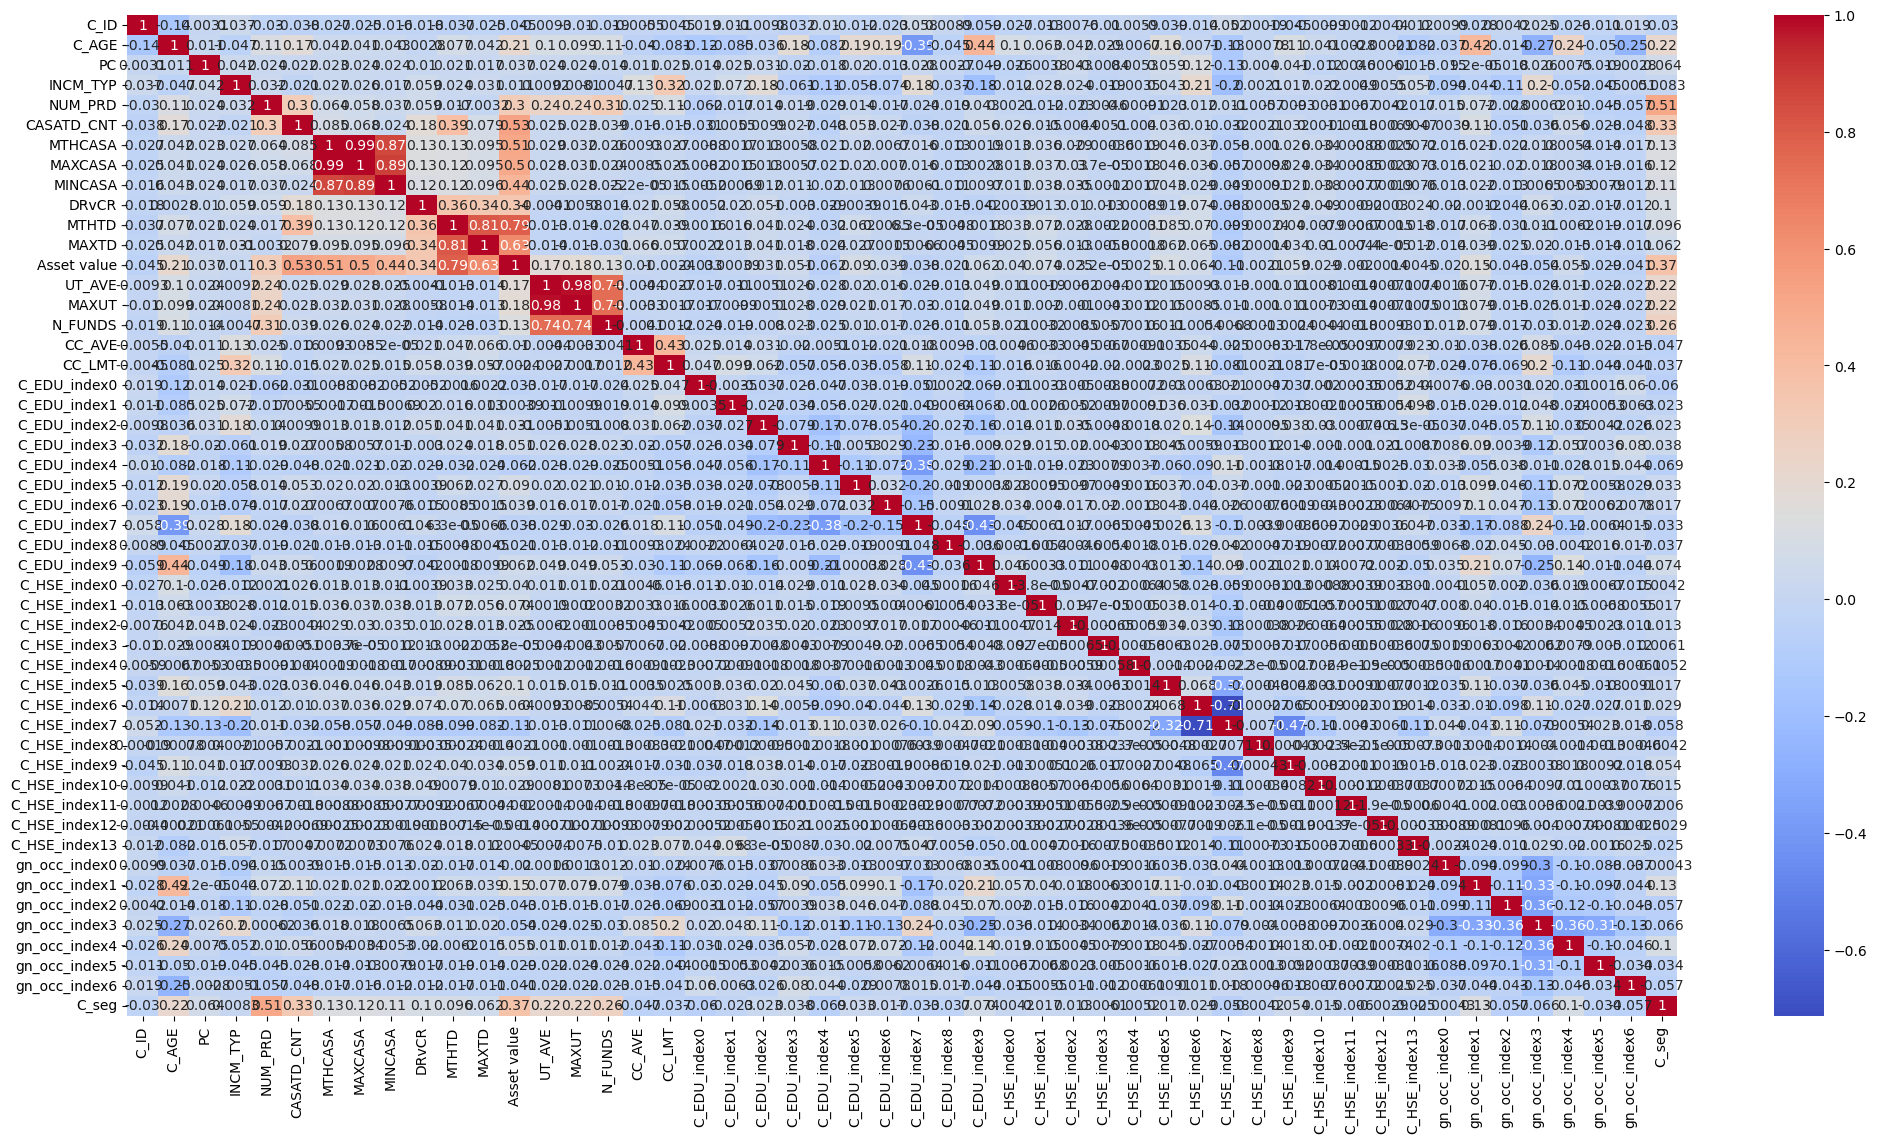

In [21]:
# Plotting correlation relationship for every pairwise columns.
# We can see that most of the columns are not correlated. 
# "lukewarm" correlation can be seen between CASA-related columns and `Asset value` column.
plt.figure(figsize=(25,13))
sns.heatmap(DATA_ADASYN.corr(), annot=True, cmap='coolwarm')

# Describing the statistics of DATA_ADASYN
# All columns have no missing data 
DATA_ADASYN.describe()

---

### Section 02.6: Dimensionality Reduction with PCA Algorithm [DATA_INIT_RED, DATA_SMOTE_RED, DATA_ADASYN_RED]
Dimensionality Reduction with PCA Algorithm by finding the best number of principal components using 95% ELBOW method and transform the dataset to lower latent dimensions with highest explained variance.
  - `DATA_INIT_RED`: Perform dimensionality reduction using `PCA algorithm` on `DATA_INIT`
  - `DATA_SMOTE_RED`: Perform dimensionality reduction using `PCA algorithm` on `DATA_SMOTE`
  - `DATA_ADASYN_RED`: Perform dimensionality reduction using `PCA algorithm` on `DATA_ADASYN`

<br> </br>

From previous Pearson correlation heatmap plots, we can see that there were few correlation features (i.e. between CASA-related features and `Asset value` and `C_seg`). 
- Upon performing PCA algorithm, we can see that the correlation heatmap plots of DATA_INIT_RED, DATA_SMOTE_RED, and DATA_ADASYN_RED are no longer correlating to each other.

<br> </br>

When we employ PCA algorithm, other than dimensionality reduction we could decouple collinearity between highly-correlating features since all principal components are orthogonal to each other. 

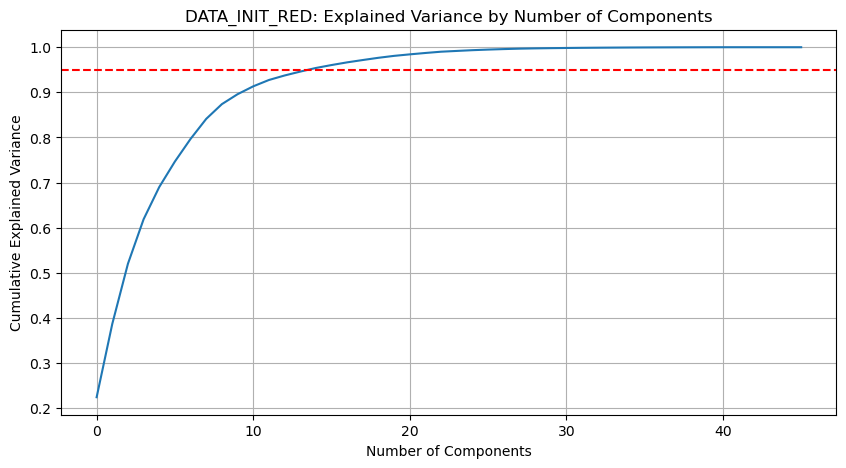

DATA_INIT_RED: Optimal number of components: 15


C_ID     C_AGE     PC       PC1       PC2       PC3       PC4   
0          0 -1.491082  20184 -0.387377 -0.396404  0.264714 -0.931390  \
1          0  0.603386  29894  0.230444 -0.373532  0.776370 -0.206574   
2          2 -0.792926  10461 -0.346765 -0.413831  0.168188 -0.184395   
3          8  1.231727  58518  0.932958 -0.202202 -1.156173 -0.541207   
4          9 -0.583479      0  1.376322 -0.590360  0.641741 -0.418272   
...      ...       ...    ...       ...       ...       ...       ...   
66078  99977 -1.560897      0 -0.822980 -0.279371 -0.013785 -0.340502   
66079  99980 -0.513663  41670 -0.740044 -0.093509  0.042887 -0.298884   
66080  99989 -0.374032  29525 -0.240285 -0.460892 -0.097824  1.253645   
66081  99990 -0.792926  81005 -0.258016 -0.215187  0.153874 -0.662708   
66082  99996 -0.723110  22209 -0.638816 -0.132633  0.116136 -0.160866   

            PC5       PC6       PC7       PC8       PC9      PC10      PC11   
0      0.657950 -0.577770  0.776134 -0.481788 -0.461413 -0.075805 -0.747904  \
1      0.476393 -0.111263 -0.421319  0.260057  0.260284  0.076843  0.522501   
2      0.608790  0.429434  0.121299 -0.623946  0.078492 -0.087951 -0.505002   
3     -1.018692 -0.098337 -0.532754 -0.099705  0.195719  0.105371 -0.566464   
4     -0.685213  0.077526 -0.023748 -0.772166  0.148394  0.033139  0.427578   
...         ...       ...       ...       ...       ...       ...       ...   
66078  0.979907  0.217327  0.151252 -0.203444  0.129785 -0.008895  0.528976   
66079  0.453380 -0.122301 -0.328659  0.305146  0.217184  0.082577  0.546025   
66080  0.563497  0.544308  0.031976 -0.794720  0.065326 -0.074715 -0.236023   
66081  0.060256 -0.865584  0.618694  0.117968 -0.676775  0.026098 -0.452550   
66082  0.458312 -0.035212 -0.382886  0.277493  0.147657  0.034599 -0.546399   

           PC12      PC13      PC14      PC15  C_seg  
0     -0.001073  0.132354  0.329037 -0.019985      0  
1     -0.090874 -0.667278 -0.219366 -0.010158      1  
2     -0.013419  0.320128  0.030058 -0.029750      0  
3     -0.042726 -0.330849 -0.169685 -0.202678      0  
4      0.370173 -0.436234  0.226049 -0.401790      0  
...         ...       ...       ...       ...    ...  
66078  0.085257 -0.038340  0.072153  0.104539      0  
66079  0.053012  0.159299  0.347069  0.254730      0  
66080 -0.011899 -0.480775 -0.622709 -0.151091      0  
66081 -0.043909  0.315386 -0.383097 -0.072359      0  
66082  0.036805  0.186655  0.010228  0.193690      0  

[66083 rows x 19 columns]

In [22]:
#####################
# DATA_INIT_RED #####
#####################

# Getting list of feature columns for PCA algorithms and it should not be one of the columns in `sorting_cols`
# This is because we don't want columns in `sorting_cols` to be reduced principal components
# We will be using `sorting_cols` as look-up keys in Section 03
dataset_name = "DATA_INIT_RED"
PCA_feature_cols = [col for col in feature_cols if col not in sorting_cols] 
sorting_df = DATA_INIT[sorting_cols]

# Preparing feature and target columns
x = DATA_INIT[PCA_feature_cols] 
y = DATA_INIT[target_cols]

# Getting list of explained variance to help finding optimal number of principal components
explained_variance = PCA().fit(x).explained_variance_ratio_

# Plotting ELBOW graph based on `expained_variance_ratio_`
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'{dataset_name}: Explained Variance by Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # Line for 95% explained variance
plt.show()

# Finding optimal number of principal components with total explained variance > 95%
n_optimal = np.where(np.cumsum(explained_variance) >= 0.95)[0][0] + 1
print(f"{dataset_name}: Optimal number of components: {n_optimal}")

# Transforming dataset into lower dimensions based on optimal number of principal components found above
transformed_df = PCA(n_components=n_optimal).fit_transform(x)
DATA_INIT_RED = pd.DataFrame(transformed_df, columns=[f'PC{i+1}' for i in range(n_optimal)])
DATA_INIT_RED = pd.concat([sorting_df, DATA_INIT_RED, y], axis=1)

DATA_INIT_RED

C_ID         C_AGE             PC           PC1           PC2   
count  66083.000000  6.608300e+04   66083.000000  6.608300e+04  6.608300e+04  \
mean   41321.249111  7.526594e-17   43667.066946 -2.731078e-17 -3.827811e-17   
std    27485.202813  1.000000e+00   26032.061441  1.911495e+00  1.627585e+00   
min        0.000000 -3.515734e+00       0.000000 -5.851230e+00 -4.296049e+01   
25%    17402.000000 -7.231101e-01   21682.000000 -5.775078e-01 -4.040997e-01   
50%    37643.000000 -2.495414e-02   41203.000000 -3.413471e-01 -2.238819e-01   
75%    62866.500000  7.430174e-01   60867.500000 -1.259367e-01 -4.966554e-02   
max    99996.000000  4.862138e+00  100000.000000  1.967555e+02  1.099014e+02   

                PC3           PC4           PC5           PC6           PC7   
count  6.608300e+04  6.608300e+04  6.608300e+04  6.608300e+04  6.608300e+04  \
mean  -2.903115e-18  8.144850e-18  7.193273e-17 -1.042164e-16  1.248877e-16   
std    1.473938e+00  1.267134e+00  1.079090e+00  9.595475e-01  9.038065e-01   
min   -1.283040e+02 -1.230008e+01 -2.000986e+01 -4.505714e+01 -3.736812e+01   
25%   -9.505734e-02 -4.351105e-01 -2.159919e-01 -3.731216e-01 -3.785383e-01   
50%    6.527436e-02 -2.572921e-01  4.311696e-01  1.827711e-02 -5.523863e-02   
75%    1.985829e-01  1.874516e-01  5.938143e-01  3.323687e-01  2.685631e-01   
max    1.397813e+02  5.653428e+01  6.501805e+01  5.315811e+01  7.882168e+01   

                PC8           PC9          PC10          PC11          PC12   
count  6.608300e+04  6.608300e+04  6.608300e+04  6.608300e+04  6.608300e+04  \
mean  -8.460698e-17 -1.296725e-16  7.123384e-19  7.230906e-18  3.035502e-17   
std    8.503845e-01  7.292690e-01  5.983405e-01  5.331554e-01  4.784314e-01   
min   -1.759505e+01 -2.265350e+01 -3.118001e+01 -2.352529e+00 -2.997552e+01   
25%   -6.023907e-01 -2.651589e-01 -4.903944e-02 -5.073850e-01 -2.757867e-02   
50%   -1.371103e-02  1.347726e-01  3.743152e-02 -1.188556e-01 -3.112818e-03   
75%    4.014296e-01  2.461968e-01  1.066541e-01  5.244889e-01  4.464993e-02   
max    4.173892e+01  2.863552e+01  3.405391e+01  3.950986e+00  6.452401e+01   

               PC13          PC14          PC15         C_seg  
count  6.608300e+04  6.608300e+04  6.608300e+04  66083.000000  
mean   4.274030e-18  5.591184e-18 -1.612842e-19      0.165338  
std    4.034235e-01  3.748902e-01  3.620407e-01      0.371488  
min   -4.192287e+00 -2.329430e+00 -2.813919e+01      0.000000  
25%   -2.458865e-01 -2.555006e-01 -1.058513e-01      0.000000  
50%    1.037672e-01 -3.101104e-02 -3.712707e-04      0.000000  
75%    2.727220e-01  2.634752e-01  1.314578e-01      0.000000  
max    5.036710e+00  3.566398e+00  3.249385e+01      1.000000

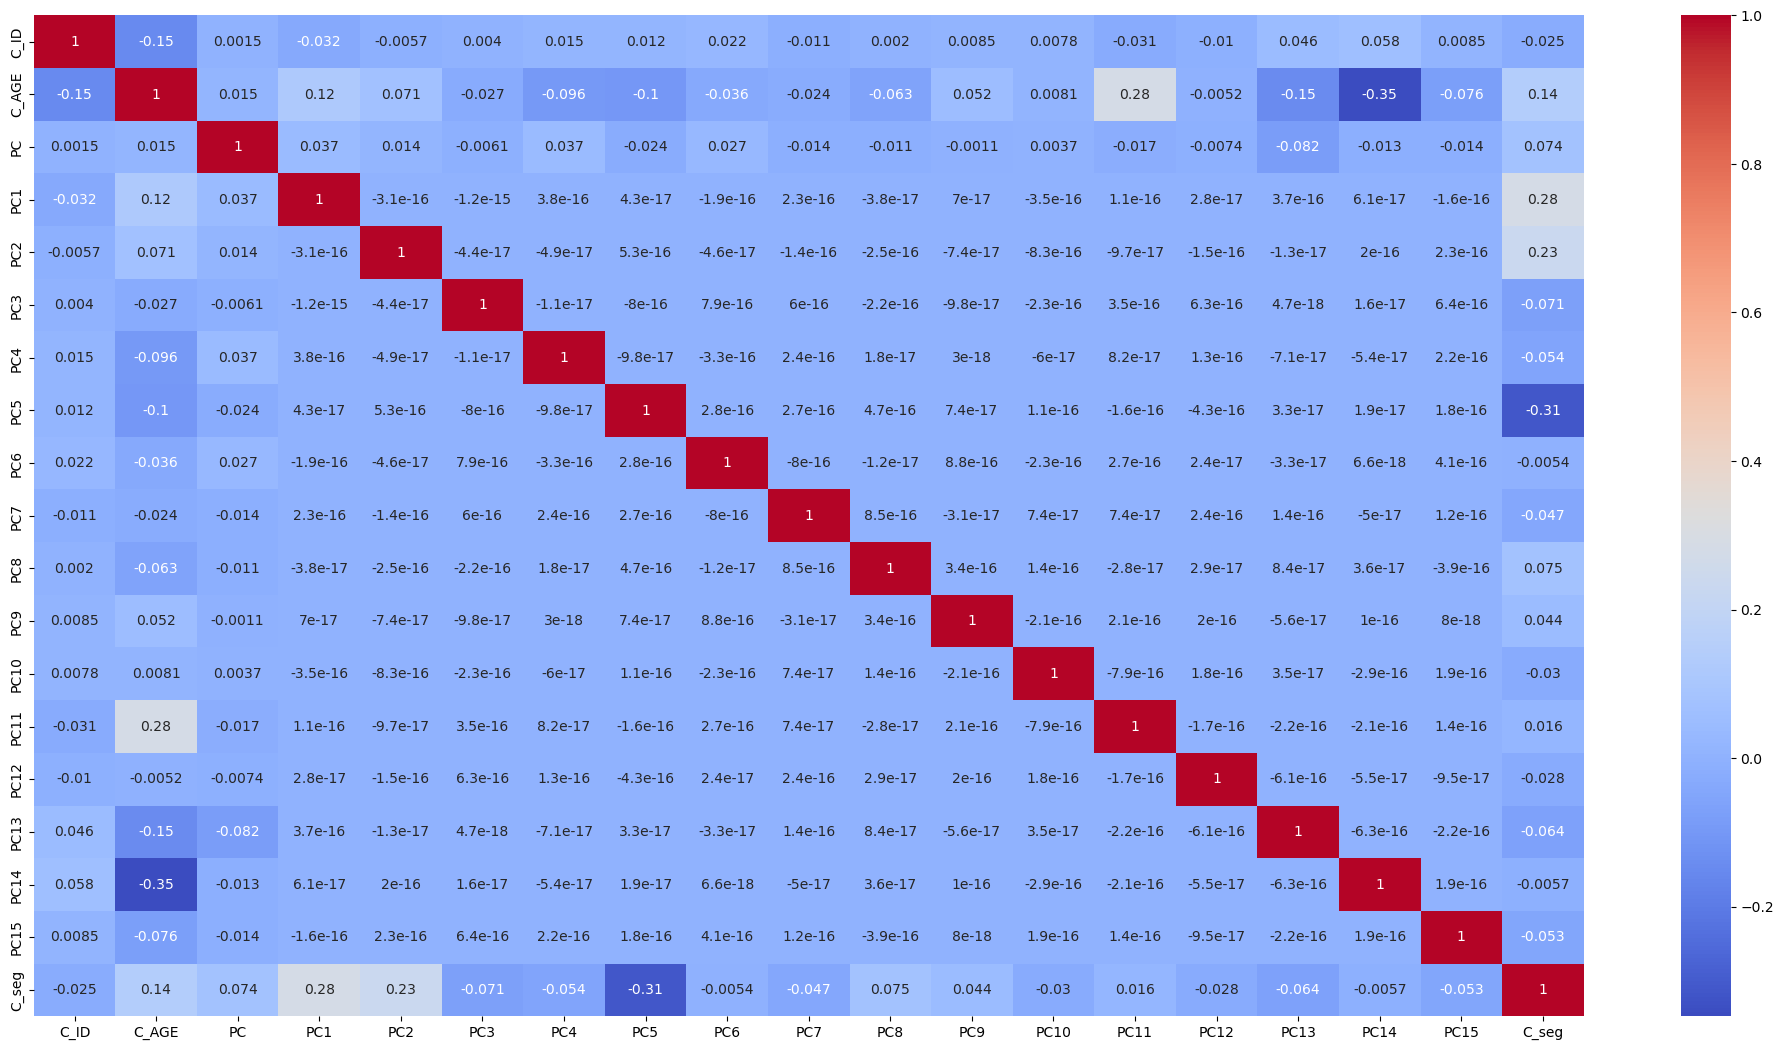

In [23]:
# Plotting correlation relationship for every pairwise columns.
# The reduced columns are now not exhibiting any correlation, thus solving potential collinearity issue
plt.figure(figsize=(25,13))
sns.heatmap(DATA_INIT_RED.corr(), annot=True, cmap='coolwarm')

# Describing dataset statistics
# No peculiarity upon dimension reduction.
DATA_INIT_RED.describe()

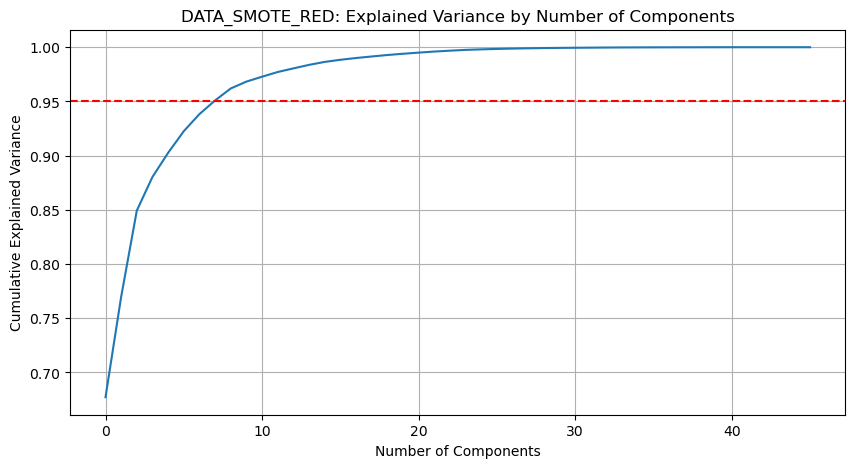

DATA_SMOTE_RED: Optimal number of components: 8


C_ID     C_AGE      PC       PC1       PC2       PC3       PC4   
0           0 -1.491082   20184 -0.544387 -0.778301 -0.415011  0.454053  \
1           0  0.603386   29894  0.277574 -0.754568 -0.728130  0.622732   
2           2 -0.792926   10461 -0.542808 -0.785817 -0.398787  0.586277   
3           8  1.231727   58518 -0.325958 -0.202575  1.277882 -0.727035   
4           9 -0.583479       0  1.029833 -0.638129  0.255307 -0.742635   
...       ...       ...     ...       ...       ...       ...       ...   
110309  33524 -1.330006  100000 -0.369446 -0.800316 -0.969773  1.563330   
110310  66373  2.641091  100000 -2.291306 -0.986283 -3.559165 -3.499524   
110311  67304 -1.895673  100000  0.389466  0.156894  2.874752 -9.670983   
110312   3171  2.073656  100000  6.168281 -1.358639 -0.843207  0.991484   
110313  54649 -0.086784  100000 -1.113710 -0.642985 -0.543894  0.921033   

             PC5       PC6       PC7       PC8  C_seg  
0       0.432687 -1.260541  0.197703 -0.414552      0  
1       0.486917 -0.259652 -0.023561  0.046505      1  
2       0.177473 -0.441833  0.513227 -0.869752      0  
3       0.574782  0.118086 -0.012970  0.322477      0  
4       0.144927 -0.393372  0.389490 -0.395359      0  
...          ...       ...       ...       ...    ...  
110309 -0.276789  1.736257  0.614478 -0.865251      1  
110310 -5.136872 -1.547179  1.056787 -0.077384      1  
110311 -0.397901 -0.351757  2.040379 -1.842906      1  
110312  0.195938 -0.648663  0.349018 -0.646448      1  
110313 -0.056704  0.768074  0.396595 -0.513923      1  

[110314 rows x 12 columns]

In [24]:
######################
# DATA_SMOTE_RED #####
######################

# Getting list of feature columns for PCA algorithms and it should not be one of the columns in `sorting_cols`
# This is because we don't want columns in `sorting_cols` to be reduced principal components
# We will be using `sorting_cols` as look-up keys in Section 03
dataset_name = "DATA_SMOTE_RED"
PCA_feature_cols = [col for col in feature_cols if col not in sorting_cols]
sorting_df = DATA_SMOTE[sorting_cols]

# Preparing feature and target columns
x = DATA_SMOTE[PCA_feature_cols] 
y = DATA_SMOTE[target_cols]

# Getting list of explained variance to help finding optimal number of principal components
explained_variance = PCA().fit(x).explained_variance_ratio_

# Plotting ELBOW graph based on `expained_variance_ratio_`
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'{dataset_name}: Explained Variance by Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # Line for 95% explained variance
plt.show()

# Finding optimal number of principal components with total explained variance > 95%
n_optimal_components = np.where(np.cumsum(explained_variance) >= 0.95)[0][0] + 1
print(f"{dataset_name}: Optimal number of components: {n_optimal_components}")

# Transforming dataset into lower dimensions based on optimal number of principal components found above
transformed_df = PCA(n_components=n_optimal_components).fit_transform(x)
DATA_SMOTE_RED = pd.DataFrame(transformed_df, columns=[f'PC{i+1}' for i in range(n_optimal_components)])
DATA_SMOTE_RED = pd.concat([sorting_df, DATA_SMOTE_RED, y], axis=1)

DATA_SMOTE_RED

C_ID          C_AGE             PC           PC1   
count  110314.000000  110314.000000  110314.000000  1.103140e+05  \
mean    40759.164222       0.081239   53507.339912  1.030575e-16   
std     27196.467385       0.985613   31228.926364  6.800891e+00   
min      -138.000000      -4.019532       0.000000 -1.186654e+02   
25%     17484.000000      -0.591642   29587.250000 -8.057848e-01   
50%     37299.500000       0.044861   50357.500000 -5.406027e-01   
75%     61073.750000       0.757890   80314.000000 -1.288195e-01   
max     99996.000000       7.260326  100660.000000  3.710081e+02   

                PC2           PC3           PC4           PC5           PC6   
count  1.103140e+05  1.103140e+05  1.103140e+05  1.103140e+05  1.103140e+05  \
mean  -1.648920e-17  7.832369e-17 -7.317082e-17  1.453111e-16  4.972524e-17   
std    2.516082e+00  2.330915e+00  1.455761e+00  1.233063e+00  1.167423e+00   
min   -2.211658e+01 -1.793666e+01 -2.187953e+01 -6.784299e+01 -2.364276e+01   
25%   -7.730764e-01 -6.468457e-01 -5.150409e-01 -2.539420e-01 -5.276425e-01   
50%   -6.248232e-01 -3.997800e-01  4.288160e-01  1.301788e-01 -2.112074e-01   
75%   -3.214523e-01 -1.246629e-01  6.775925e-01  3.795242e-01  2.688604e-01   
max    1.172618e+02  1.370071e+02  6.578868e+01  8.323149e+01  5.800807e+01   

                PC7           PC8          C_seg  
count  1.103140e+05  1.103140e+05  110314.000000  
mean  -3.040196e-17 -8.811415e-17       0.500000  
std    1.037402e+00  9.276690e-01       0.500002  
min   -2.587810e+01 -1.466266e+01       0.000000  
25%   -2.185233e-01 -5.752157e-01       0.000000  
50%    4.137574e-02  3.900987e-02       0.500000  
75%    3.999109e-01  5.318866e-01       1.000000  
max    3.870902e+01  1.969820e+01       1.000000

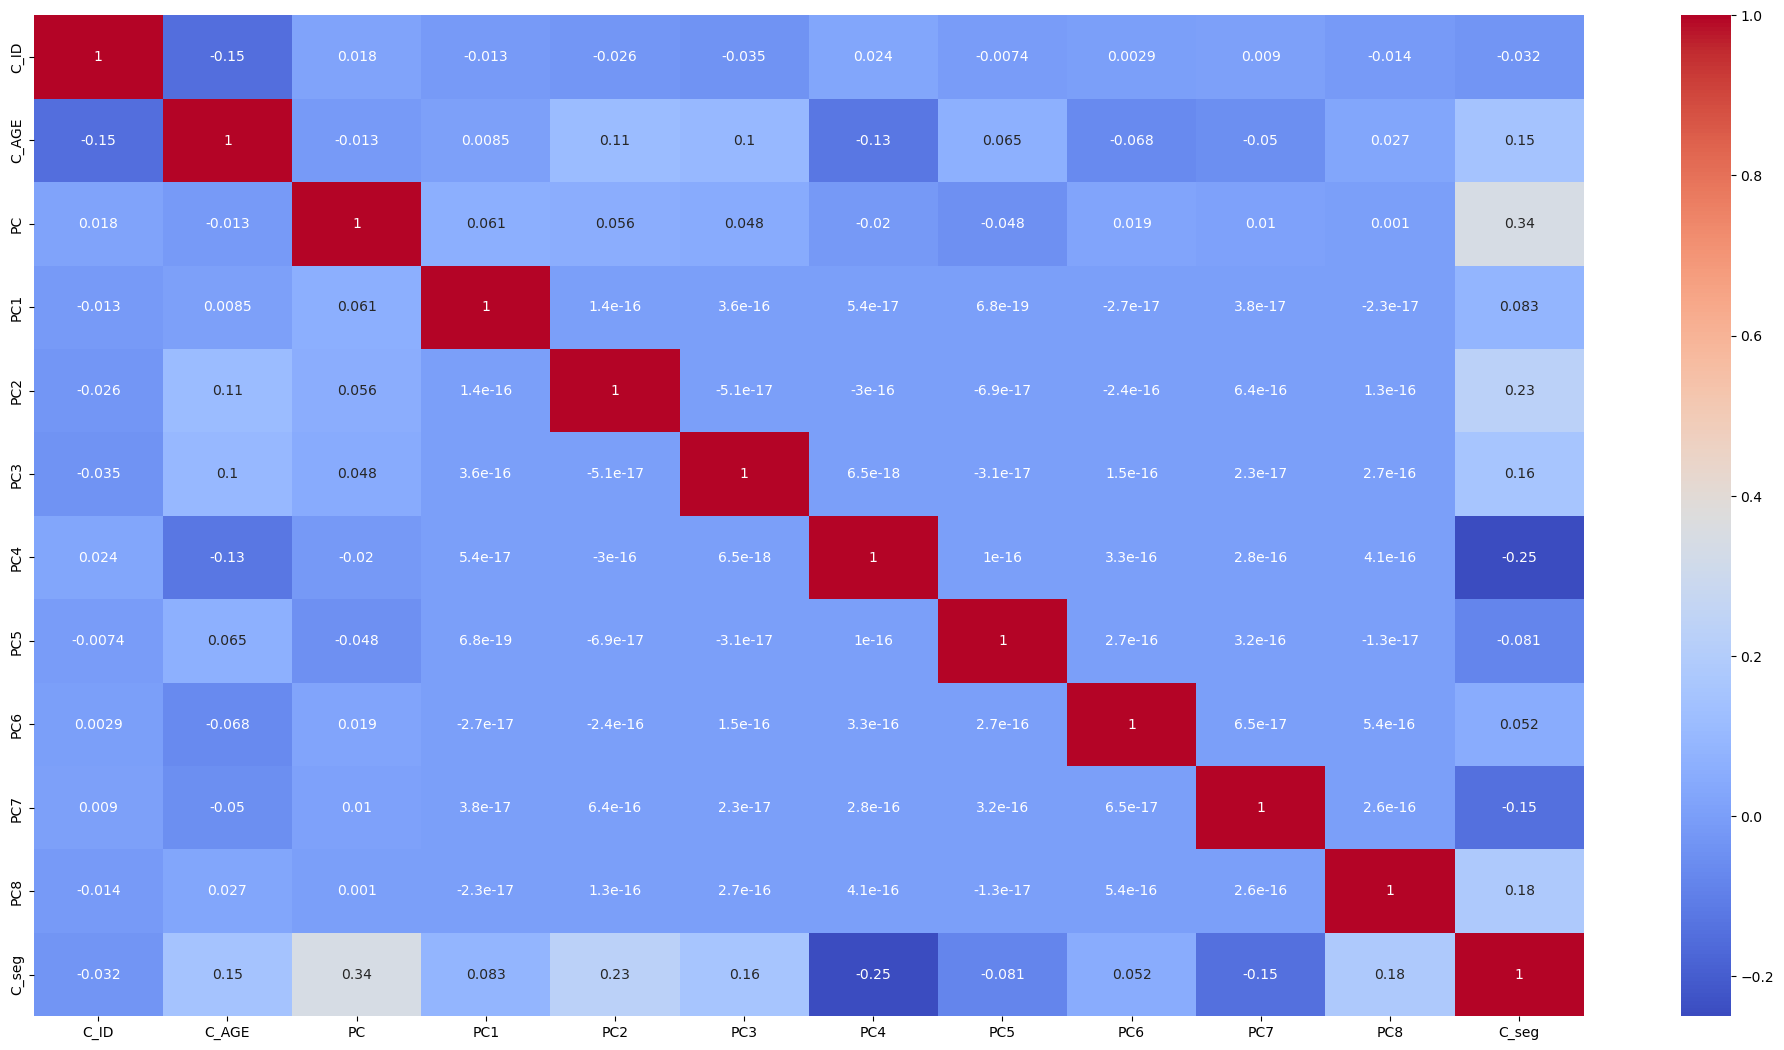

In [25]:
# Plotting correlation relationship for every pairwise columns.
# The reduced columns are now not exhibiting any correlation, thus solving potential collinearity issue
plt.figure(figsize=(25,13))
sns.heatmap(DATA_SMOTE_RED.corr(), annot=True, cmap='coolwarm')

# Describing dataset statistics
# No peculiarity upon dimension reduction.
DATA_SMOTE_RED.describe()

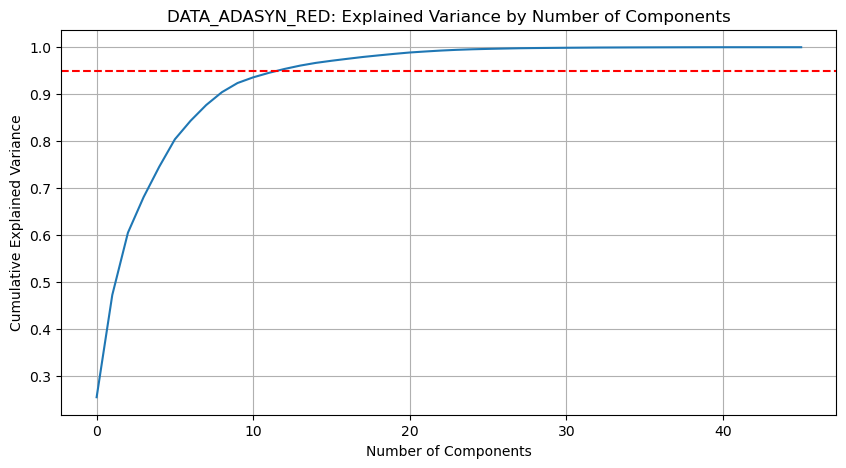

DATA_ADASYN_RED: Optimal number of components: 13


C_ID     C_AGE     PC       PC1       PC2       PC3       PC4   
0           0 -1.491082  20184 -1.076666 -0.169128  0.192479  0.550530  \
1           0  0.603386  29894 -0.716931  0.120520  0.939847  0.584062   
2           2 -0.792926  10461 -1.060682 -0.142932  0.185832  0.730576   
3           8  1.231727  58518 -0.040283  0.943130 -0.989265 -0.744093   
4           9 -0.583479      0 -0.069751  1.180166  0.833160 -0.613730   
...       ...       ...    ...       ...       ...       ...       ...   
109615  99481  0.686295   1390 -0.430261  0.173824 -0.303255 -0.925211   
109616  99659 -0.599290    128  0.028300  0.915671 -1.420878 -1.580190   
109617  99414 -0.477976    113 -0.357103  0.310089 -0.893300 -1.322457   
109618  99352  1.017211   1722 -0.495995  0.049491 -0.067451 -0.828562   
109619  99634 -0.519281    114 -0.286996  0.443523 -1.016535 -1.312125   

             PC5       PC6       PC7       PC8       PC9      PC10      PC11   
0      -1.145637 -0.460024 -0.501842  1.016873  0.167753 -0.443892 -0.777108  \
1      -0.583491  0.233923  0.126400 -0.184976 -0.069104  0.210155  0.514917   
2      -0.456441 -0.115866 -0.890494 -0.131528  0.285024  0.018057 -0.524512   
3      -0.227419  0.271144  0.108588 -0.289838 -0.203015  0.130815 -0.571714   
4      -0.344113 -0.136937 -0.733594 -0.024629  0.104624  0.134001  0.346622   
...          ...       ...       ...       ...       ...       ...       ...   
109615  0.108177  0.265806 -0.029867 -0.678939 -0.181358  0.434682  0.534298   
109616  0.707174  0.469621 -0.593526 -1.314016 -0.048154  0.553204  0.410055   
109617  0.405466  0.351290 -0.516257 -1.025569 -0.055450  0.499979  0.187343   
109618 -0.001347  0.193694  0.139593 -0.493215 -0.231258  0.376304  0.541129   
109619  0.453611  0.426154 -0.580406 -1.168869 -0.029782  0.562115  0.312918   

            PC12      PC13  C_seg  
0      -0.002720  0.081844      0  
1      -0.044394 -0.217231      1  
2      -0.025223  0.134610      0  
3      -0.026952  0.096086      0  
4       0.502907  0.283235      0  
...          ...       ...    ...  
109615 -0.027393  0.473372      1  
109616 -0.120065  0.767603      1  
109617 -0.066835  0.643301      1  
109618 -0.013560  0.376214      1  
109619 -0.072175  0.722731      1  

[109620 rows x 17 columns]

In [26]:
######################
# DATA_ADASYN_RED #####
######################

# Getting list of feature columns for PCA algorithms and it should not be one of the columns in `sorting_cols`
# This is because we don't want columns in `sorting_cols` to be reduced principal components
# We will be using `sorting_cols` as look-up keys in Section 03
dataset_name = "DATA_ADASYN_RED"
PCA_feature_cols = [col for col in feature_cols if col not in sorting_cols] 
sorting_df = DATA_ADASYN[sorting_cols]

# Preparing feature and target columns
x = DATA_ADASYN[PCA_feature_cols] 
y = DATA_ADASYN[target_cols]

# Getting list of explained variance to help finding optimal number of principal components
explained_variance = PCA().fit(x).explained_variance_ratio_

# Plotting ELBOW graph based on `expained_variance_ratio_`
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'{dataset_name}: Explained Variance by Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # Line for 95% explained variance
plt.show()

# Finding optimal number of principal components with total explained variance > 95%
n_optimal_components = np.where(np.cumsum(explained_variance) >= 0.95)[0][0] + 1
print(f"{dataset_name}: Optimal number of components: {n_optimal_components}")

# Transforming dataset into lower dimensions based on optimal number of principal components found above
transformed_df = PCA(n_components=n_optimal_components).fit_transform(x)
DATA_ADASYN_RED = pd.DataFrame(transformed_df, columns=[f'PC{i+1}' for i in range(n_optimal_components)])
DATA_ADASYN_RED = pd.concat([sorting_df, DATA_ADASYN_RED, y], axis=1)

DATA_ADASYN_RED

C_ID          C_AGE             PC           PC1   
count  109620.000000  109620.000000  109620.000000  1.096200e+05  \
mean    40805.985806       0.133461   44458.923965 -8.296795e-18   
std     27375.922699       0.914997   25792.409273  2.306458e+00   
min         0.000000      -3.515734       0.000000 -3.201078e+00   
25%     17114.750000      -0.513663   22854.750000 -1.048665e+00   
50%     36831.000000       0.141219   41677.000000 -7.758416e-01   
75%     61919.250000       0.784129   61129.000000  3.017428e-02   
max     99996.000000       4.862138  100000.000000  1.043918e+02   

                PC2           PC3           PC4           PC5           PC6   
count  1.096200e+05  1.096200e+05  1.096200e+05  1.096200e+05  1.096200e+05  \
mean  -5.185497e-17 -2.566821e-17  5.807757e-17 -5.185497e-17 -5.237352e-17   
std    2.127129e+00  1.660119e+00  1.254349e+00  1.160042e+00  1.102087e+00   
min   -5.297303e+01 -9.092786e+01 -1.894281e+01 -2.333980e+01 -7.570162e+01   
25%   -5.383379e-01 -1.831175e-01 -5.851446e-01 -5.732134e-01 -2.782468e-01   
50%   -1.530724e-01  6.659831e-02  3.546233e-01 -2.292800e-01 -5.914059e-02   
75%    1.734092e-01  1.873887e-01  6.908889e-01  3.135944e-01  2.340295e-01   
max    1.410585e+02  1.767007e+02  6.500091e+01  4.203640e+01  8.619078e+01   

                PC7           PC8           PC9          PC10          PC11   
count  1.096200e+05  1.096200e+05  1.096200e+05  1.096200e+05  1.096200e+05  \
mean   7.467116e-17  6.118887e-17 -1.646395e-17 -4.278035e-17 -9.722807e-18   
std    9.039156e-01  8.358117e-01  7.526301e-01  6.375640e-01  5.009748e-01   
min   -2.183309e+01 -4.290341e+00 -2.732463e+01 -2.170479e+01 -2.767130e+00   
25%   -5.575712e-01 -2.703400e-01 -2.767759e-01 -1.859856e-01 -4.779666e-01   
50%    9.585025e-02 -9.384902e-02 -6.968686e-02  9.443531e-02  1.126933e-02   
75%    5.178825e-01  2.558902e-01  1.999342e-01  2.149157e-01  4.781193e-01   
max    2.979236e+01  4.750533e+01  3.030731e+01  3.568171e+01  3.794628e+00   

               PC12          PC13          C_seg  
count  1.096200e+05  1.096200e+05  109620.000000  
mean   1.330080e-16 -5.856371e-17       0.496835  
std    4.459505e-01  4.151294e-01       0.499992  
min   -1.997847e+01 -3.005466e+01       0.000000  
25%   -5.901596e-02 -1.488599e-01       0.000000  
50%   -9.558632e-03  2.355000e-04       0.000000  
75%    2.753814e-02  1.366904e-01       1.000000  
max    6.841144e+01  3.554902e+01       1.000000

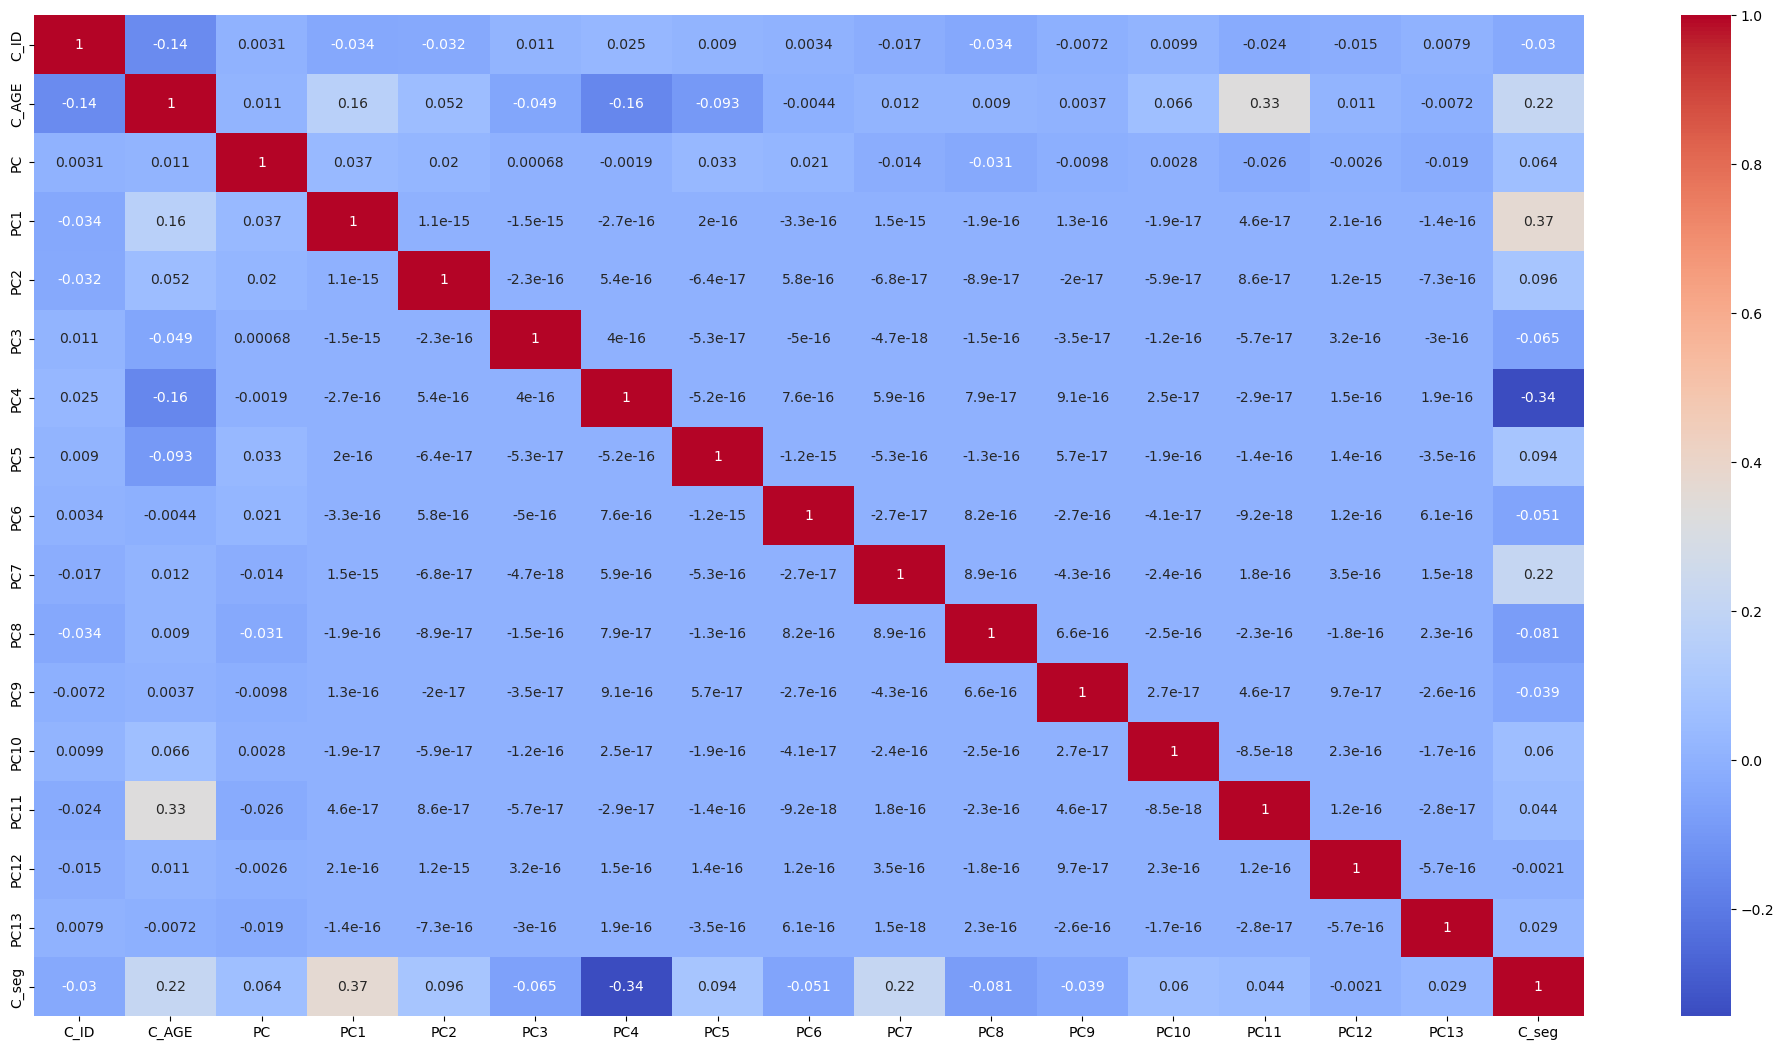

In [27]:
# Plotting correlation relationship for every pairwise columns.
# The reduced columns are now not exhibiting any correlation, thus solving potential collinearity issue
plt.figure(figsize=(25,13))
sns.heatmap(DATA_ADASYN_RED.corr(), annot=True, cmap='coolwarm')

# Describing dataset statistics
# No peculiarity upon dimension reduction.
DATA_ADASYN_RED.describe()

In [ ]:
for dataset_name, dataset_df in dataset_df_dict.items():
    with open(dataset_name+".pkl", "wb") as file:
        pickle.dump(dataset_df, file)

---

## Section 03: Model Training & Evaluation

<font color="blue">List of models used for the training and the rationales on why using them:</font>
- XGBoostClassifier
  - Handling imbalanced data: This model is well-suited for imbalanced datasets that fits our data imbalance scenario between <b>`NORMAL`</b> and <b>`AFFLUENT`</b> customer segments. The gradient boosting helps to potentially improving performance on the minority class.
  - High performance: This model showcases state-of-the-art results on classification problems with ability to perform ensemble learning and capture complex inherent patterns in the data.
  - Tunability: It offers a wide variety of regularization options to prevent overfittiing with excellent documentation.
- GaussianNB
  - Speeed and simplicity: This model is extremely fast and easy to implement which makes it a good choice as baseline models where computational resources are limited.
  - Probabilistic interpretation: It gives probabilistic approach which is valueable for decision making based on probabilities of belonging to a certain class.
- KNeighborsClassifier
  - Non-Linearity and complexity: This model can capture non-linear boundaries between classes without any assumption on data distribution which is suitable for complex features and target class.
- LogisticRegression
  - Baseline model: Just like Gaussian Naive Bayes, this model makes another good option as simple and efficient baseline mode.
  - Probability outputs: This model provides probability for class memberships that's useful for gaining confidence in model prediction.
$$
%- SVC 
%  - Versatility in non-linear classification problem: This model can efficiently perform non-linear classification by capturing intricate relationship between features that linear models might miss
%  - Robustness: SVC is effective in high-dimensional spaces and relatively immune to overfitting, especially in cases where the number of dimensions exceeds the number of samples.
$$
  
<font color="blue">Step-by-step strategy for model training and hyper parameter tuning:</font>
1. There are in total of 6 datasets which we will train the model and tune the hyper parameters on. The details of these 6 datasets have been captured in the table below.
1. There are 5 powerful classifier models which will be trained and tuned on each dataset in previous step. The details of these classifier models have been discussed above.
1. During each model training, <b>`StratifiedKFold()`</b> library is used to provide a list of unique dataset subset for test set according to the number of splits. 
      - For our purpose, `n_splits`=5 is chosen which means that there are 5 unique and non-overlapping test sets. Here, the ratio between training set and test set is 4:1
 1. For each split, we will train model and tune hyper parameter of the model in question on said split's training set using <b>`GridSearchCV()`</b> library that incorporates 3-fold cross validation. 
       - The best combination in parameter grid will then be used to predict the probability of a datapoint belonging to `NORMAL` segment in becoming `AFFLUENT` segment.
       - Parameter tuning is based on `f1_score` parameter which fits our scenario with imbalance dataset.
       - Then, we consolidate those data points and use `C_AGE_stats` and `reference_unique_recods` to ensure these are actual data points and not synthetically generated by `SMOTE` or `ADASYN` oversampling techniques.
 1. Upon iterating all test set splits, all identified `NORMAL` datapoints with high probability to become `AFFLUENT` class are collated. 
       - At the end of model training and parameter tuning for each dataset, we will retain a tuple of collated potential data points for class upgrade, average f1-score among all test set splits, and average ROC AUC score among all test set splits.

<br><br>

<font color="blue">Summary of all datasets, each of which will be trained and tuned on both aforementioned classifier models:</font>

| DATASET VARIABLE NAME | DESCRIPTION |
|:---------------------:|:-----------:|
| `DATA_INIT`             | Normalized dataset with all one-hot encoded categorical columns being expanded out as separate columns.|
| `DATA_SMOTE`            | Basically it's the same as `DATA_INIT` but we perform oversampling on minority customer segment `AFFLUENT` using <font color="red">`SMOTE`</font> technique to resolve data imbalance issue against customer segment `NORMAL`.|
| `DATA_ADASYN`           | Basically it's the same as `DATA_INIT` but we perform oversampling on minority customer segment `AFFLUENT` using <font color="red">`ADASYN`</font> technique to resolve data imbalance issue against customer segment `NORMAL`.|
| `DATA_INIT_RED`         | Basically it's the same as `DATA_INIT` but we perform dimensionality reduction using PCA algorithm which also helps resolving collinearity issue on some feature columns.|
| `DATA_SMOTE_RED`        | Basically it's the same as `DATA_SMOTE` but we perform dimensionality reduction using PCA algorithm which also helps resolving collinearity issue on some feature columns.|
| `DATA_ADASYN_RED`       | Basically it's the same as `DATA_ADASYN` but we perform dimensionality reduction using PCA algorithm which also helps resolving collinearity issue on some feature columns.|


In [51]:
def is_actual_data(x):
    C_ID_data  = x["C_ID"]  #  int64
    C_AGE_data = x["C_AGE"] #float64
    PC_data    = x["PC"]    #  int64
    C_seg_data = x["C_seg"] #  int64
    
    # Since column `C_AGE` is of float64 dtype, we cannot use equality but rather use 
    # tolerance in the difference against a reference.
    float_equality_tolerance = 1e-3
    
    for C_ID_ref, C_AGE_ref, PC_ref, C_seg_ref in reference_unique_records:
        cond = (C_ID_ref==C_ID_data)
        C_AGE_reconstructed = C_AGE_data*C_AGE_stats["std"]+C_AGE_stats["mean"]
        cond &= (abs(C_AGE_ref-C_AGE_reconstructed)<float_equality_tolerance)
        cond &= (PC_ref==PC_data)
        cond &= (C_seg_ref==C_seg_data)
        if cond:
            return True
        
    return False


def clf_trainer(input_df, dataset_name, estimator, parameters):
    print("Current Time:", strftime("%H:%M:%S", localtime()))
    
    # Setting threshold_pct as 0.9 which means that the minimum threshold for 
    # a `NORMAL` datapoints to be upgraded to `AFFLUENT` customer
    # is 90% of maximum probability in terms of predicted likelihood to be 
    # an `AFFLUENT` customer from any other `NORMAL` data points. 
    threshold_pct = 0.9
    
    # Setting number of stratified fold to 5 which means that there are 5 unique
    # non-overlapping test sets partitioned from `input_df`
    n_splits = 5

    key = input_df[["C_ID", "PC"]]
    
    # If `input_df` is a reduced dataset owing to PCA, use different feature columns 
    if "PC1" in input_df.columns:
        PCA_feature_cols = [col for col in input_df.columns.tolist() if len(col)>=3 and "PC" in col]
    else:
        PCA_feature_cols = [col for col in feature_cols if col not in sorting_cols]
    
    # Preparing feature columns and target column
    x = input_df[["C_AGE"]+PCA_feature_cols]
    y = input_df[target_cols]
    
    # Partitioning `input_df` so that no data points in any test set is repeatedly sampled
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    time_list, upgrade_list, model_list  = [], [], []
    for i, (train_index, test_index) in tqdm(enumerate(skf.split(x, y)), desc=f"Training + Tuning + Evaluating...", ascii=False, ncols=75):
        key_train, key_test = key.iloc[train_index], key.iloc[test_index]
        x_train,   x_test   =   x.iloc[train_index],   x.iloc[test_index]
        y_train,   y_test   =   y.iloc[train_index],   y.iloc[test_index]    

        # Use F1-score as evaluation metrics during parameter tuning.
        f1_scorer = make_scorer(f1_score)

        start = time()
        model = GridSearchCV(estimator=estimator,
                              param_grid=parameters, 
                              cv=3, 
                              scoring=f1_scorer, 
                              verbose=0, 
                              return_train_score=True,
                             ).fit(x_train, y_train)
        
        # Getting the probability of being `AFFLUENT`
        affluent_prob = model.best_estimator_.predict_proba(x_test)[:, 1]
        
        # Computing threshold to determine if a `NORMAL` data point is likely enough 
        # to be upgraded to `AFFLUENT` class
        threshold = max(affluent_prob.max()*threshold_pct, 0.7)
        
        # Formulating a filter mask to get data points classified as `NORMAL` 
        # but with high `AFFLUENT` probability 
        likelihood_indices = (y_test == 0) & (affluent_prob > threshold)
        likelihood_df    = pd.concat([key_test[likelihood_indices], x_test[likelihood_indices], y_test[likelihood_indices]], axis=1)
        
        # Further filtering to ensure the identified data points are actual customer data 
        # and not synthetic data
        actual_data_mask = likelihood_df.apply(lambda x: is_actual_data(x[sorting_cols+[target_cols]]), axis=1)
        
        # If there is no actual customer data that satisfies the criteria, 
        # continue to next stratified split.
        count = sum(actual_data_mask.tolist())
        if count==0:
            time_list.append(0)
            upgrade_list += [pd.DataFrame()]
            model_list += [estimator]
            del likelihood_df, model, affluent_prob, likelihood_indices, actual_data_mask, x_train, y_train, x_test, y_test
            continue
        
        # Applying the `actual_data_mask` to the `likelihood_df`
        likelihood_df    = likelihood_df[actual_data_mask]
        likelihood_df["C_AGE"] = likelihood_df["C_AGE"].apply(lambda x: int(x*C_AGE_stats["std"]+C_AGE_stats["mean"]))
        likelihood_df[target_cols] = "NORMAL" 
        end = time()
        
        # Appending interim results from the splits to few lists
        time_list.append(end-start)
        upgrade_list += [likelihood_df[sorting_cols+[target_cols]]]
        model_list += [model]
        del likelihood_df, model, affluent_prob, likelihood_indices, actual_data_mask, x_train, y_train, x_test, y_test

    # Computing average f1-score and ROC AUC score across all test set splits with non-zero identified data points
    mean_test_f1score, mean_test_rocaucscore, it = 0, 0, 0
    for i, (train_index, test_index) in enumerate(skf.split(x, y)):
        if time_list[i]==0: continue
        x_test, y_test = x.iloc[test_index], y.iloc[test_index]
        test_f1score = f1_score(y_test, model_list[i].best_estimator_.predict(x_test))
        mean_test_f1score += test_f1score
        test_rocaucscore = roc_auc_score(y_test, model_list[i].best_estimator_.predict_proba(x_test)[:, 1])
        mean_test_rocaucscore += test_rocaucscore
        print(f"{dataset_name} Split {i}: Count {len(upgrade_list[i])}, TestF1Score {test_f1score:.2f}, TestROC-AUCScore {test_rocaucscore:.2f}")
        #print(f'Best Params: {model_list[i].best_params_}')
        it+=1
    
    # Returning consolidated data points that are identified to fulfill the criteria, 
    # average f1-score across all test setsplits,
    # and average ROC AUC score across all test set splits.
    if it!=0:
        mean_test_f1score /= it
        mean_test_rocaucscore /= it
        upgrade_df = pd.concat(upgrade_list, axis=0).sort_values(by=sorting_cols).reset_index(drop=True)
    else:
        mean_test_f1score = 0
        mean_test_rocaucscore = 0
        upgrade_df = pd.DataFrame()
    #upgrade_df["PC"] = upgrade_df["PC"].apply(lambda x: np.nan if x==100000 else x)
    return upgrade_df, mean_test_f1score, mean_test_rocaucscore



# svc_params = { #This model runs too long
#     'C': [0.1, 1, 10],
#     'kernel': ['rbf'],
#     'gamma': ['scale', 'auto']
# }

xgb_params = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.3, 0.7]
}

knn_params = {
    'n_neighbors': [3, 5, 7],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto', 'ball_tree', ]
}

logreg_params = {
    'C': [0.01, 0.1, 1, 10],  
    'solver': ['newton-cg', 'liblinear', 'sag'],  
    'penalty': ['l2'],  
    'max_iter': [100, 200, 300]  
}

gnb_params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

dataset_df_dict     = {"DATA_INIT":DATA_INIT,         "DATA_SMOTE":DATA_SMOTE,         "DATA_ADASYN":DATA_ADASYN, 
                       "DATA_INIT_RED":DATA_INIT_RED, "DATA_SMOTE_RED":DATA_SMOTE_RED, "DATA_ADASYN_RED":DATA_ADASYN_RED,
                      }
estimator_dict      = {#"SVC":[SVC(probability=True), svc_params], #This model runs too long
                       "XGBoostClassifier" :[XGBClassifier(), xgb_params], 
                       "KNeighborsClassifier":[KNeighborsClassifier(), knn_params],
                       "LogisticRegression":[LogisticRegression(), logreg_params],
                       "GaussianNB":[GaussianNB(), gnb_params],
                      }

In [38]:
# Gathering results from all model training sessions and all datasets into `consolidated_result`
consolidated_result = [] #upgrade_df, mean_test_f1score, mean_test_rocaucscore

# Looping across all datasets and model estimators.
for i, (dataset_name, dataset_df) in enumerate(dataset_df_dict.items()):
    for estimator_name, estimator in estimator_dict.items():
        print("\n\n\n============================================")
        print(f"{dataset_name} + {estimator_name:}")
        print("============================================")
        consolidated_result.append(clf_trainer(dataset_df, dataset_name, estimator[0], estimator[1]))

# Saving `consolidated_result` into a pickle file so that
#  we can load it whenever we want without having to rerun the long model training
with open("consolidated_result.pkl", "wb") as file:
    pickle.dump(consolidated_result, file)




DATA_INIT + XGBoostClassifier
Current Time: 23:13:00


Training + Tuning + Evaluating...: 5it [28:54, 346.85s/it]


DATA_INIT Split 0: Count 22, TestF1Score 0.58, TestROC-AUCScore 0.90
DATA_INIT Split 1: Count 15, TestF1Score 0.58, TestROC-AUCScore 0.90
DATA_INIT Split 2: Count 18, TestF1Score 0.57, TestROC-AUCScore 0.89
DATA_INIT Split 3: Count 17, TestF1Score 0.60, TestROC-AUCScore 0.90
DATA_INIT Split 4: Count 29, TestF1Score 0.59, TestROC-AUCScore 0.90



DATA_INIT + KNeighborsClassifier
Current Time: 23:41:54


Training + Tuning + Evaluating...: 5it [1:33:30, 1122.13s/it]


DATA_INIT Split 0: Count 24, TestF1Score 0.52, TestROC-AUCScore 0.84
DATA_INIT Split 1: Count 20, TestF1Score 0.51, TestROC-AUCScore 0.83
DATA_INIT Split 2: Count 26, TestF1Score 0.50, TestROC-AUCScore 0.83
DATA_INIT Split 3: Count 26, TestF1Score 0.53, TestROC-AUCScore 0.84
DATA_INIT Split 4: Count 33, TestF1Score 0.51, TestROC-AUCScore 0.83



DATA_INIT + LogisticRegression
Current Time: 01:15:29


Training + Tuning + Evaluating...: 0it [00:00, ?it/s]/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which me

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

DATA_INIT Split 0: Count 29, TestF1Score 0.49, TestROC-AUCScore 0.87
DATA_INIT Split 1: Count 29, TestF1Score 0.48, TestROC-AUCScore 0.87
DATA_INIT Split 2: Count 32, TestF1Score 0.48, TestROC-AUCScore 0.86
DATA_INIT Split 3: Count 42, TestF1Score 0.49, TestROC-AUCScore 0.87
DATA_INIT Split 4: Count 45, TestF1Score 0.50, TestROC-AUCScore 0.87



DATA_INIT + GaussianNB
Current Time: 01:23:15


Training + Tuning + Evaluating...: 5it [01:44, 20.83s/it]


DATA_INIT Split 0: Count 1158, TestF1Score 0.51, TestROC-AUCScore 0.82
DATA_INIT Split 1: Count 1142, TestF1Score 0.51, TestROC-AUCScore 0.81
DATA_INIT Split 2: Count 840, TestF1Score 0.51, TestROC-AUCScore 0.81
DATA_INIT Split 3: Count 957, TestF1Score 0.54, TestROC-AUCScore 0.83
DATA_INIT Split 4: Count 1053, TestF1Score 0.54, TestROC-AUCScore 0.83



DATA_SMOTE + XGBoostClassifier
Current Time: 01:25:00


Training + Tuning + Evaluating...: 5it [44:52, 538.41s/it]


DATA_SMOTE Split 0: Count 14, TestF1Score 0.90, TestROC-AUCScore 0.96
DATA_SMOTE Split 1: Count 22, TestF1Score 0.91, TestROC-AUCScore 0.97
DATA_SMOTE Split 2: Count 12, TestF1Score 0.91, TestROC-AUCScore 0.97
DATA_SMOTE Split 3: Count 9, TestF1Score 0.91, TestROC-AUCScore 0.97
DATA_SMOTE Split 4: Count 21, TestF1Score 0.91, TestROC-AUCScore 0.97



DATA_SMOTE + KNeighborsClassifier
Current Time: 02:09:52


Training + Tuning + Evaluating...: 5it [5:37:49, 4053.84s/it]


DATA_SMOTE Split 0: Count 480, TestF1Score 0.90, TestROC-AUCScore 0.94
DATA_SMOTE Split 1: Count 492, TestF1Score 0.90, TestROC-AUCScore 0.95
DATA_SMOTE Split 2: Count 464, TestF1Score 0.90, TestROC-AUCScore 0.95
DATA_SMOTE Split 3: Count 452, TestF1Score 0.90, TestROC-AUCScore 0.95
DATA_SMOTE Split 4: Count 452, TestF1Score 0.90, TestROC-AUCScore 0.94



DATA_SMOTE + LogisticRegression
Current Time: 07:53:23


Training + Tuning + Evaluating...: 0it [00:00, ?it/s]/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which me

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

DATA_SMOTE Split 0: Count 242, TestF1Score 0.81, TestROC-AUCScore 0.89
DATA_SMOTE Split 1: Count 235, TestF1Score 0.82, TestROC-AUCScore 0.89
DATA_SMOTE Split 2: Count 229, TestF1Score 0.81, TestROC-AUCScore 0.89
DATA_SMOTE Split 3: Count 248, TestF1Score 0.81, TestROC-AUCScore 0.89
DATA_SMOTE Split 4: Count 236, TestF1Score 0.81, TestROC-AUCScore 0.89



DATA_SMOTE + GaussianNB
Current Time: 08:08:10


Training + Tuning + Evaluating...: 5it [03:16, 39.31s/it]


DATA_SMOTE Split 0: Count 2894, TestF1Score 0.78, TestROC-AUCScore 0.85
DATA_SMOTE Split 1: Count 2712, TestF1Score 0.78, TestROC-AUCScore 0.86
DATA_SMOTE Split 2: Count 2088, TestF1Score 0.79, TestROC-AUCScore 0.86
DATA_SMOTE Split 3: Count 887, TestF1Score 0.75, TestROC-AUCScore 0.86
DATA_SMOTE Split 4: Count 2061, TestF1Score 0.78, TestROC-AUCScore 0.85



DATA_ADASYN + XGBoostClassifier
Current Time: 08:11:27


Training + Tuning + Evaluating...: 5it [44:05, 529.03s/it]


DATA_ADASYN Split 0: Count 2, TestF1Score 0.91, TestROC-AUCScore 0.97
DATA_ADASYN Split 1: Count 16, TestF1Score 0.90, TestROC-AUCScore 0.97
DATA_ADASYN Split 2: Count 1, TestF1Score 0.90, TestROC-AUCScore 0.97
DATA_ADASYN Split 4: Count 21, TestF1Score 0.90, TestROC-AUCScore 0.97



DATA_ADASYN + KNeighborsClassifier
Current Time: 08:55:33


Training + Tuning + Evaluating...: 5it [5:21:30, 3858.05s/it]


DATA_ADASYN Split 0: Count 371, TestF1Score 0.89, TestROC-AUCScore 0.95
DATA_ADASYN Split 1: Count 250, TestF1Score 0.89, TestROC-AUCScore 0.95
DATA_ADASYN Split 2: Count 235, TestF1Score 0.89, TestROC-AUCScore 0.95
DATA_ADASYN Split 3: Count 335, TestF1Score 0.90, TestROC-AUCScore 0.95
DATA_ADASYN Split 4: Count 352, TestF1Score 0.90, TestROC-AUCScore 0.95



DATA_ADASYN + LogisticRegression
Current Time: 14:17:13


Training + Tuning + Evaluating...: 0it [00:00, ?it/s]/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which me

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training + Tuning + Evaluating...: 5it [14:02, 168.45s/it]


DATA_ADASYN Split 0: Count 303, TestF1Score 0.81, TestROC-AUCScore 0.90
DATA_ADASYN Split 1: Count 300, TestF1Score 0.81, TestROC-AUCScore 0.90
DATA_ADASYN Split 2: Count 299, TestF1Score 0.81, TestROC-AUCScore 0.90
DATA_ADASYN Split 3: Count 288, TestF1Score 0.81, TestROC-AUCScore 0.90
DATA_ADASYN Split 4: Count 282, TestF1Score 0.81, TestROC-AUCScore 0.90



DATA_ADASYN + GaussianNB
Current Time: 14:31:15


Training + Tuning + Evaluating...: 5it [03:14, 39.00s/it]


DATA_ADASYN Split 0: Count 2202, TestF1Score 0.79, TestROC-AUCScore 0.85
DATA_ADASYN Split 1: Count 2058, TestF1Score 0.79, TestROC-AUCScore 0.84
DATA_ADASYN Split 2: Count 1845, TestF1Score 0.79, TestROC-AUCScore 0.85
DATA_ADASYN Split 3: Count 2768, TestF1Score 0.77, TestROC-AUCScore 0.85
DATA_ADASYN Split 4: Count 1858, TestF1Score 0.80, TestROC-AUCScore 0.85



DATA_INIT_RED + XGBoostClassifier
Current Time: 14:34:30


Training + Tuning + Evaluating...: 5it [21:32, 258.42s/it]


DATA_INIT_RED Split 0: Count 20, TestF1Score 0.57, TestROC-AUCScore 0.89
DATA_INIT_RED Split 1: Count 16, TestF1Score 0.55, TestROC-AUCScore 0.89
DATA_INIT_RED Split 2: Count 32, TestF1Score 0.54, TestROC-AUCScore 0.88
DATA_INIT_RED Split 3: Count 13, TestF1Score 0.57, TestROC-AUCScore 0.89
DATA_INIT_RED Split 4: Count 30, TestF1Score 0.57, TestROC-AUCScore 0.89



DATA_INIT_RED + KNeighborsClassifier
Current Time: 14:56:02


Training + Tuning + Evaluating...: 5it [13:42, 164.42s/it]


DATA_INIT_RED Split 0: Count 35, TestF1Score 0.52, TestROC-AUCScore 0.83
DATA_INIT_RED Split 1: Count 66, TestF1Score 0.51, TestROC-AUCScore 0.82
DATA_INIT_RED Split 2: Count 24, TestF1Score 0.51, TestROC-AUCScore 0.83
DATA_INIT_RED Split 3: Count 36, TestF1Score 0.53, TestROC-AUCScore 0.84
DATA_INIT_RED Split 4: Count 29, TestF1Score 0.52, TestROC-AUCScore 0.84



DATA_INIT_RED + LogisticRegression
Current Time: 15:09:47


Training + Tuning + Evaluating...: 0it [00:00, ?it/s]/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which me

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

DATA_INIT_RED Split 0: Count 36, TestF1Score 0.46, TestROC-AUCScore 0.85
DATA_INIT_RED Split 1: Count 30, TestF1Score 0.46, TestROC-AUCScore 0.85
DATA_INIT_RED Split 2: Count 35, TestF1Score 0.45, TestROC-AUCScore 0.85
DATA_INIT_RED Split 3: Count 45, TestF1Score 0.46, TestROC-AUCScore 0.86
DATA_INIT_RED Split 4: Count 44, TestF1Score 0.48, TestROC-AUCScore 0.86



DATA_INIT_RED + GaussianNB
Current Time: 15:11:42


Training + Tuning + Evaluating...: 5it [00:46,  9.29s/it]


DATA_INIT_RED Split 0: Count 320, TestF1Score 0.44, TestROC-AUCScore 0.84
DATA_INIT_RED Split 1: Count 329, TestF1Score 0.41, TestROC-AUCScore 0.84
DATA_INIT_RED Split 2: Count 324, TestF1Score 0.40, TestROC-AUCScore 0.83
DATA_INIT_RED Split 3: Count 346, TestF1Score 0.46, TestROC-AUCScore 0.84
DATA_INIT_RED Split 4: Count 334, TestF1Score 0.45, TestROC-AUCScore 0.85



DATA_SMOTE_RED + XGBoostClassifier
Current Time: 15:12:29


Training + Tuning + Evaluating...: 5it [25:13, 302.77s/it]


DATA_SMOTE_RED Split 0: Count 97, TestF1Score 0.91, TestROC-AUCScore 0.97
DATA_SMOTE_RED Split 1: Count 106, TestF1Score 0.91, TestROC-AUCScore 0.97
DATA_SMOTE_RED Split 2: Count 100, TestF1Score 0.90, TestROC-AUCScore 0.96
DATA_SMOTE_RED Split 3: Count 101, TestF1Score 0.91, TestROC-AUCScore 0.97
DATA_SMOTE_RED Split 4: Count 89, TestF1Score 0.90, TestROC-AUCScore 0.96



DATA_SMOTE_RED + KNeighborsClassifier
Current Time: 15:37:43


Training + Tuning + Evaluating...: 5it [29:54, 358.84s/it]


DATA_SMOTE_RED Split 0: Count 326, TestF1Score 0.88, TestROC-AUCScore 0.94
DATA_SMOTE_RED Split 1: Count 349, TestF1Score 0.89, TestROC-AUCScore 0.94
DATA_SMOTE_RED Split 2: Count 322, TestF1Score 0.89, TestROC-AUCScore 0.94
DATA_SMOTE_RED Split 3: Count 328, TestF1Score 0.89, TestROC-AUCScore 0.94
DATA_SMOTE_RED Split 4: Count 296, TestF1Score 0.88, TestROC-AUCScore 0.94



DATA_SMOTE_RED + LogisticRegression
Current Time: 16:07:43


Training + Tuning + Evaluating...: 0it [00:00, ?it/s]/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which me

Training + Tuning + Evaluating...: 5it [01:52, 22.58s/it]


DATA_SMOTE_RED Split 0: Count 160, TestF1Score 0.76, TestROC-AUCScore 0.82
DATA_SMOTE_RED Split 1: Count 170, TestF1Score 0.77, TestROC-AUCScore 0.83
DATA_SMOTE_RED Split 2: Count 146, TestF1Score 0.76, TestROC-AUCScore 0.82
DATA_SMOTE_RED Split 3: Count 167, TestF1Score 0.76, TestROC-AUCScore 0.83
DATA_SMOTE_RED Split 4: Count 147, TestF1Score 0.76, TestROC-AUCScore 0.83



DATA_SMOTE_RED + GaussianNB
Current Time: 16:09:36


Training + Tuning + Evaluating...: 5it [00:54, 10.95s/it]


DATA_SMOTE_RED Split 0: Count 336, TestF1Score 0.52, TestROC-AUCScore 0.84
DATA_SMOTE_RED Split 1: Count 327, TestF1Score 0.52, TestROC-AUCScore 0.85
DATA_SMOTE_RED Split 2: Count 334, TestF1Score 0.52, TestROC-AUCScore 0.84
DATA_SMOTE_RED Split 3: Count 358, TestF1Score 0.55, TestROC-AUCScore 0.85
DATA_SMOTE_RED Split 4: Count 331, TestF1Score 0.53, TestROC-AUCScore 0.85



DATA_ADASYN_RED + XGBoostClassifier
Current Time: 16:10:31


Training + Tuning + Evaluating...: 5it [29:29, 353.99s/it]


DATA_ADASYN_RED Split 0: Count 117, TestF1Score 0.90, TestROC-AUCScore 0.97
DATA_ADASYN_RED Split 1: Count 104, TestF1Score 0.90, TestROC-AUCScore 0.97
DATA_ADASYN_RED Split 2: Count 96, TestF1Score 0.90, TestROC-AUCScore 0.97
DATA_ADASYN_RED Split 3: Count 99, TestF1Score 0.90, TestROC-AUCScore 0.97
DATA_ADASYN_RED Split 4: Count 111, TestF1Score 0.91, TestROC-AUCScore 0.97



DATA_ADASYN_RED + KNeighborsClassifier
Current Time: 16:40:01


Training + Tuning + Evaluating...: 5it [40:24, 484.83s/it]


DATA_ADASYN_RED Split 0: Count 270, TestF1Score 0.88, TestROC-AUCScore 0.94
DATA_ADASYN_RED Split 1: Count 251, TestF1Score 0.88, TestROC-AUCScore 0.94
DATA_ADASYN_RED Split 2: Count 250, TestF1Score 0.88, TestROC-AUCScore 0.94
DATA_ADASYN_RED Split 3: Count 346, TestF1Score 0.88, TestROC-AUCScore 0.94
DATA_ADASYN_RED Split 4: Count 239, TestF1Score 0.88, TestROC-AUCScore 0.94



DATA_ADASYN_RED + LogisticRegression
Current Time: 17:20:39


Training + Tuning + Evaluating...: 0it [00:00, ?it/s]/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which me

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training + Tuning + Evaluating...: 2it [01:21, 41.31s/it]/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached whic

/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jameslim/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

DATA_ADASYN_RED Split 0: Count 308, TestF1Score 0.80, TestROC-AUCScore 0.89
DATA_ADASYN_RED Split 1: Count 300, TestF1Score 0.80, TestROC-AUCScore 0.89
DATA_ADASYN_RED Split 2: Count 288, TestF1Score 0.80, TestROC-AUCScore 0.89
DATA_ADASYN_RED Split 3: Count 290, TestF1Score 0.80, TestROC-AUCScore 0.89
DATA_ADASYN_RED Split 4: Count 278, TestF1Score 0.80, TestROC-AUCScore 0.89



DATA_ADASYN_RED + GaussianNB
Current Time: 17:24:03


Training + Tuning + Evaluating...: 5it [01:04, 12.91s/it]

DATA_ADASYN_RED Split 0: Count 427, TestF1Score 0.60, TestROC-AUCScore 0.86
DATA_ADASYN_RED Split 1: Count 430, TestF1Score 0.59, TestROC-AUCScore 0.86
DATA_ADASYN_RED Split 2: Count 428, TestF1Score 0.58, TestROC-AUCScore 0.86
DATA_ADASYN_RED Split 3: Count 446, TestF1Score 0.60, TestROC-AUCScore 0.86
DATA_ADASYN_RED Split 4: Count 441, TestF1Score 0.59, TestROC-AUCScore 0.87


In [84]:
# Loading saved `consolidated_result`
with open("consolidated_result.pkl", "rb") as file:
    consolidated_result = pickle.load(file)

# Printing the content of `consolidated_result`
for i, (output_df, avg_f1score, avg_rocaucscore) in enumerate(consolidated_result):
    dataset_iterator = i // len(estimator_dict)
    estimator_iterator = i % len(estimator_dict)
    
    # Previously, all missing rows from column `PC` were filled with arbitrary number `100000`
    # So the following line reverts them back to NaN for easier identification purpose when cross-checked against input Excel file.
    output_df["PC"] = output_df["PC"].apply(lambda x: np.nan if x==100000 else x)
    
    # Printing `consolidated_result`
    print("\n\n\n============================================")
    print(f"RESULT :: {list(dataset_df_dict.keys())[dataset_iterator]} + {list(estimator_dict.keys())[estimator_iterator]}")
    print("============================================")
    print(f"Average      F1 score across all test set splits: {avg_f1score:.4f}")
    print(f"Average ROC-AUC score across all test set splits: {avg_rocaucscore:.4f}")
    print(f"\nIdentified NORMAL customers that are recommended to be upgraded:\n{output_df}")




RESULT :: DATA_INIT + XGBoostClassifier
Average      F1 score across all test set splits: 0.5822
Average ROC-AUC score across all test set splits: 0.8980

Identified NORMAL customers that are recommended to be upgraded:
      C_ID  C_AGE     PC   C_seg
0       11     70  22167  NORMAL
1      533     49  57616  NORMAL
2      592     70  56747  NORMAL
3     1672     68  70263  NORMAL
4     1770     68  50207  NORMAL
..     ...    ...    ...     ...
96   94551     63  87079  NORMAL
97   96244     47  77721  NORMAL
98   96322     68  31764  NORMAL
99   96667     41  70629  NORMAL
100  98296     63  90003  NORMAL

[101 rows x 4 columns]



RESULT :: DATA_INIT + KNeighborsClassifier
Average      F1 score across all test set splits: 0.5152
Average ROC-AUC score across all test set splits: 0.8341

Identified NORMAL customers that are recommended to be upgraded:
      C_ID  C_AGE     PC   C_seg
0      592     70  56747  NORMAL
1      664     82  99698  NORMAL
2     1186     47  10208  NORMAL

---

## Section 04: Selection strategy on NORMAL Customers for Upgrade to AFFLUENT segment

We explored multiple data processing techniques which give us 6 different dataset and we also used 4 different classifier models to predict likelihood of <b>`NORMAL`</b> customers that are fits better to be upgraded into <b>`AFFLUENT`</b> customer segment.

<br></br>

**There are multiple strategies to select custoemr list for upgrade depending on business situations:**
<br><br>
<ins>Strategy A: Prioritize Based on Project Objective<ins>
  * <font color="blue">1. If Precision is More Important:</font> If the primary objective is to ensure that the identified <b>`NORMAL`</b> customers with a high probability of being <b>`AFFLUENT`</b>" are indeed likely to be <b>`AFFLUENT`</b> (i.e. minimizing False Positives), we can select recommended customers offered by model with highest average F1 score across all test set splits. 
    * The F1 score balances precision and recall, making it suitable when both are important, but it leans towards models that maintain high precision.
  * <font color="blue">2. If Overall Model Performance is Key:</font> If you're looking for a model that balances the trade-off between true positive rate and false positive rate over various thresholds, we should consider the recommended customers offered by model with highest average ROC AUC score across all test set splits.
      * A higher ROC AUC score indicates a model's ability to distinguish between the two classes across all thresholds.

<br></br>
<ins>Strategy B: Composite Evaluation Metrics<ins>
  * <font color="blue">Weighted Decision:</font> We can create a weighted metric that combines both the average F1 score and the average ROC AUC score according to their importance to your project. For instance, if both metrics are equally important, you could rank models based on the sum of average of their normalized scores and select the model with the highest composite score.
  
<br></br>
    
<font color="red"><b>An important note for business decision makers:</b></font>
* <ins>Consider the Business Impact:</ins> The choice between models might come down to the business context. 
  - For example, if targeting <b>`AFFLUENT`</b> customers incorrectly is much more costly than missing out on some, we might prioritize precision (and thus F1 score). 
  - Conversely, if reaching as many potential <b>`AFFLUENT`</b> customers as possible is more critical, even at the risk of some false positives, the ROC AUC might be more relevant.

In [121]:
#####################################################
# Strategy A1: Prioritize based on F1 score #########
#####################################################

best_dataset_based_on_f1 = ""
best_model_based_on_f1 = ""
selected_customers_for_upgrade_based_on_f1 = pd.DataFrame()

# Collating list of average F1 score across all test set splits for each dataset and each model
avg_f1score_list = [result[1] for result in consolidated_result]

max_avg_f1score = 0.0
for i, avg_f1score in enumerate(avg_f1score_list):
    if avg_f1score>max_avg_f1score:
        max_avg_f1score = avg_f1score
        dataset_iterator = i // len(estimator_dict)
        estimator_iterator = i % len(estimator_dict)
        
        best_dataset_based_on_f1 = list(dataset_df_dict.keys())[dataset_iterator]
        best_model_based_on_f1 = list(estimator_dict.keys())[estimator_iterator]
        selected_customers_for_upgrade_based_on_f1 = consolidated_result[i][0]

selected_customers_for_upgrade_based_on_f1.to_csv("Recommended_Customers_StrategyA1.csv", index=False)

# Printing list of `NORMAL` customers that should have been upgraded to `AFFLUENT` segment
print("\n\n#####################################################")
print("# Strategy A1: Prioritize based on F1 score #########")
print("#####################################################")
print(f"\nBest average F1 score across all test set splits: {max_avg_f1score:.4f}")
print(f"\nBest Dataset Based on F1 score: {best_dataset_based_on_f1}")
print(f"Best Model   Based on F1 score: {best_model_based_on_f1}")
print(f"\nSelected NORMAL Customers Needing Upgrade to AFFLUENT Customers:")
selected_customers_for_upgrade_based_on_f1



#####################################################
# Strategy A1: Prioritize based on F1 score #########
#####################################################

Best average F1 score across all test set splits: 0.9066

Best Dataset Based on F1 score: DATA_SMOTE
Best Model   Based on F1 score: XGBoostClassifier

Selected NORMAL Customers Needing Upgrade to AFFLUENT Customers:


C_ID  C_AGE     PC   C_seg
0     533     49  57616  NORMAL
1    1672     68  70263  NORMAL
2    2089     84  19713  NORMAL
3    3780     31   7852  NORMAL
4    4765     47   5601  NORMAL
..    ...    ...    ...     ...
73  88905     74  27477  NORMAL
74  89381     28  89042  NORMAL
75  89899     57  29777  NORMAL
76  94346     59  38619  NORMAL
77  94677     59  73908  NORMAL

[78 rows x 4 columns]

In [122]:
#####################################################
# Strategy A2: Prioritize based on ROC AUC score ####
#####################################################

best_dataset_based_on_rocauc = ""
best_model_based_on_rocauc = ""
selected_customers_for_upgrade_based_on_rocauc = pd.DataFrame()

# Collating list of average ROC AUC score across all test set splits for each dataset and each model
avg_rocaucscore_list = [result[2] for result in consolidated_result]

max_avg_rocaucscore = 0.0
for i, avg_rocaucscore in enumerate(avg_rocaucscore_list):
    if avg_rocaucscore>max_avg_rocaucscore:
        max_avg_rocaucscore = avg_rocaucscore
        dataset_iterator = i // len(estimator_dict)
        estimator_iterator = i % len(estimator_dict)
        
        best_dataset_based_on_rocauc = list(dataset_df_dict.keys())[dataset_iterator]
        best_model_based_on_rocauc = list(estimator_dict.keys())[estimator_iterator]
        selected_customers_for_upgrade_based_on_rocauc = consolidated_result[i][0]

selected_customers_for_upgrade_based_on_rocauc.to_csv("Recommended_Customers_StrategyA2.csv", index=False)
        
# Printing list of `NORMAL` customers that should have been upgraded to `AFFLUENT` segment
print("\n\n#####################################################")
print("# Strategy A2: Prioritize based on ROC AUC score ####")
print("#####################################################")
print(f"\nBest average ROC AUC score across all test set splits: {max_avg_rocaucscore:.4f}")
print(f"\nBest Dataset Based on ROC AUC score: {best_dataset_based_on_rocauc}")
print(f"Best Model   Based on ROC AUC score: {best_model_based_on_rocauc}")
print(f"\nSelected NORMAL Customers Needing Upgrade to AFFLUENT Customers:")
selected_customers_for_upgrade_based_on_rocauc



#####################################################
# Strategy A2: Prioritize based on ROC AUC score ####
#####################################################

Best average ROC AUC score across all test set splits: 0.9678

Best Dataset Based on ROC AUC score: DATA_SMOTE
Best Model   Based on ROC AUC score: XGBoostClassifier

Selected NORMAL Customers Needing Upgrade to AFFLUENT Customers:


C_ID  C_AGE     PC   C_seg
0     533     49  57616  NORMAL
1    1672     68  70263  NORMAL
2    2089     84  19713  NORMAL
3    3780     31   7852  NORMAL
4    4765     47   5601  NORMAL
..    ...    ...    ...     ...
73  88905     74  27477  NORMAL
74  89381     28  89042  NORMAL
75  89899     57  29777  NORMAL
76  94346     59  38619  NORMAL
77  94677     59  73908  NORMAL

[78 rows x 4 columns]

In [123]:
#####################################################
# Strategy B: Composite Evaluation Metrics ##########
#####################################################

best_dataset_based_on_comp = ""
best_model_based_on_comp = ""
selected_customers_for_upgrade_based_on_comp = pd.DataFrame()

# Collating list of average F1 score & ROC AUC with 1:1 weightage across all test set splits for each dataset and each model
avg_compscore_list = [0.5*result[1]+0.5*result[2] for result in consolidated_result]

max_avg_compscore = 0.0
for i, avg_compscore in enumerate(avg_compscore_list):
    if avg_compscore>max_avg_compscore:
        max_avg_compscore = avg_compscore
        dataset_iterator = i // len(estimator_dict)
        estimator_iterator = i % len(estimator_dict)
        
        best_dataset_based_on_comp = list(dataset_df_dict.keys())[dataset_iterator]
        best_model_based_on_comp = list(estimator_dict.keys())[estimator_iterator]
        selected_customers_for_upgrade_based_on_comp = consolidated_result[i][0]

selected_customers_for_upgrade_based_on_comp.to_csv("Recommended_Customers_StrategyB.csv", index=False)

# Printing list of `NORMAL` customers that should have been upgraded to `AFFLUENT` segment
print("\n\n#####################################################")
print("# Strategy B: Composite Evaluation Metrics ##########")
print("#####################################################")
print(f"\nBest average Composite score across all test set splits: {max_avg_compscore:.4f}")
print(f"\nBest Dataset Based on Composite score: {best_dataset_based_on_comp}")
print(f"Best Model   Based on Composite score: {best_model_based_on_comp}")
print(f"\nSelected NORMAL Customers Needing Upgrade to AFFLUENT Customers:")
selected_customers_for_upgrade_based_on_comp



#####################################################
# Strategy B: Composite Evaluation Metrics ##########
#####################################################

Best average Composite score across all test set splits: 0.9372

Best Dataset Based on Composite score: DATA_SMOTE
Best Model   Based on Composite score: XGBoostClassifier

Selected NORMAL Customers Needing Upgrade to AFFLUENT Customers:


C_ID  C_AGE     PC   C_seg
0     533     49  57616  NORMAL
1    1672     68  70263  NORMAL
2    2089     84  19713  NORMAL
3    3780     31   7852  NORMAL
4    4765     47   5601  NORMAL
..    ...    ...    ...     ...
73  88905     74  27477  NORMAL
74  89381     28  89042  NORMAL
75  89899     57  29777  NORMAL
76  94346     59  38619  NORMAL
77  94677     59  73908  NORMAL

[78 rows x 4 columns]

---

## Section 05: Sanity Check on Recommended Customers for Segment Upgrade

Just for sanity check, let's see if the strategy output makes sense. To do this, let's choose <b>`Strategy A1`</b> and select one of the customer entries on suggested list for upgrade to <b>`AFFLUENT`</b> segment.
    
We can see from the printing below that customer with `C_ID`=94677, `C_AGE`=59,and `PC`=73908 has the potential to be an <b>`AFFLUENT`</b> customer due to his/her `Asset value` that far exceeds the average `Asset value` of <b>`NORMAL`</b> customers, and even exceeding average `Asset value` of <b>`AFFLUENT`</b> customers.
    
<font color="green"><b><br>Conclusion: This customer has the potential to be an <b>`AFFLUENT`</b> customer.</br></b></font>



In [137]:
selected_customers_for_upgrade_based_on_f1.iloc[-1]

C_ID      94677
C_AGE        59
PC        73908
C_seg    NORMAL
Name: 77, dtype: object

In [142]:
raw_df[(raw_df["C_ID"]==94677) & (raw_df["C_AGE"]==59) & (raw_df["PC"]==73908)][sorting_cols+["Asset value"]]

C_ID  C_AGE       PC  Asset value
29136  94677     59  73908.0    330025.65

In [135]:
merged_stats[["Asset value"]].loc["mean"]

Asset value    {NORMAL: 19336.59, AFFLUENT: 120523.50}
Name: mean, dtype: object